# Volatility Prediction

In [2]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
stocks = 'AAPL'
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2021, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
ret = 100 * (s_p500.pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()

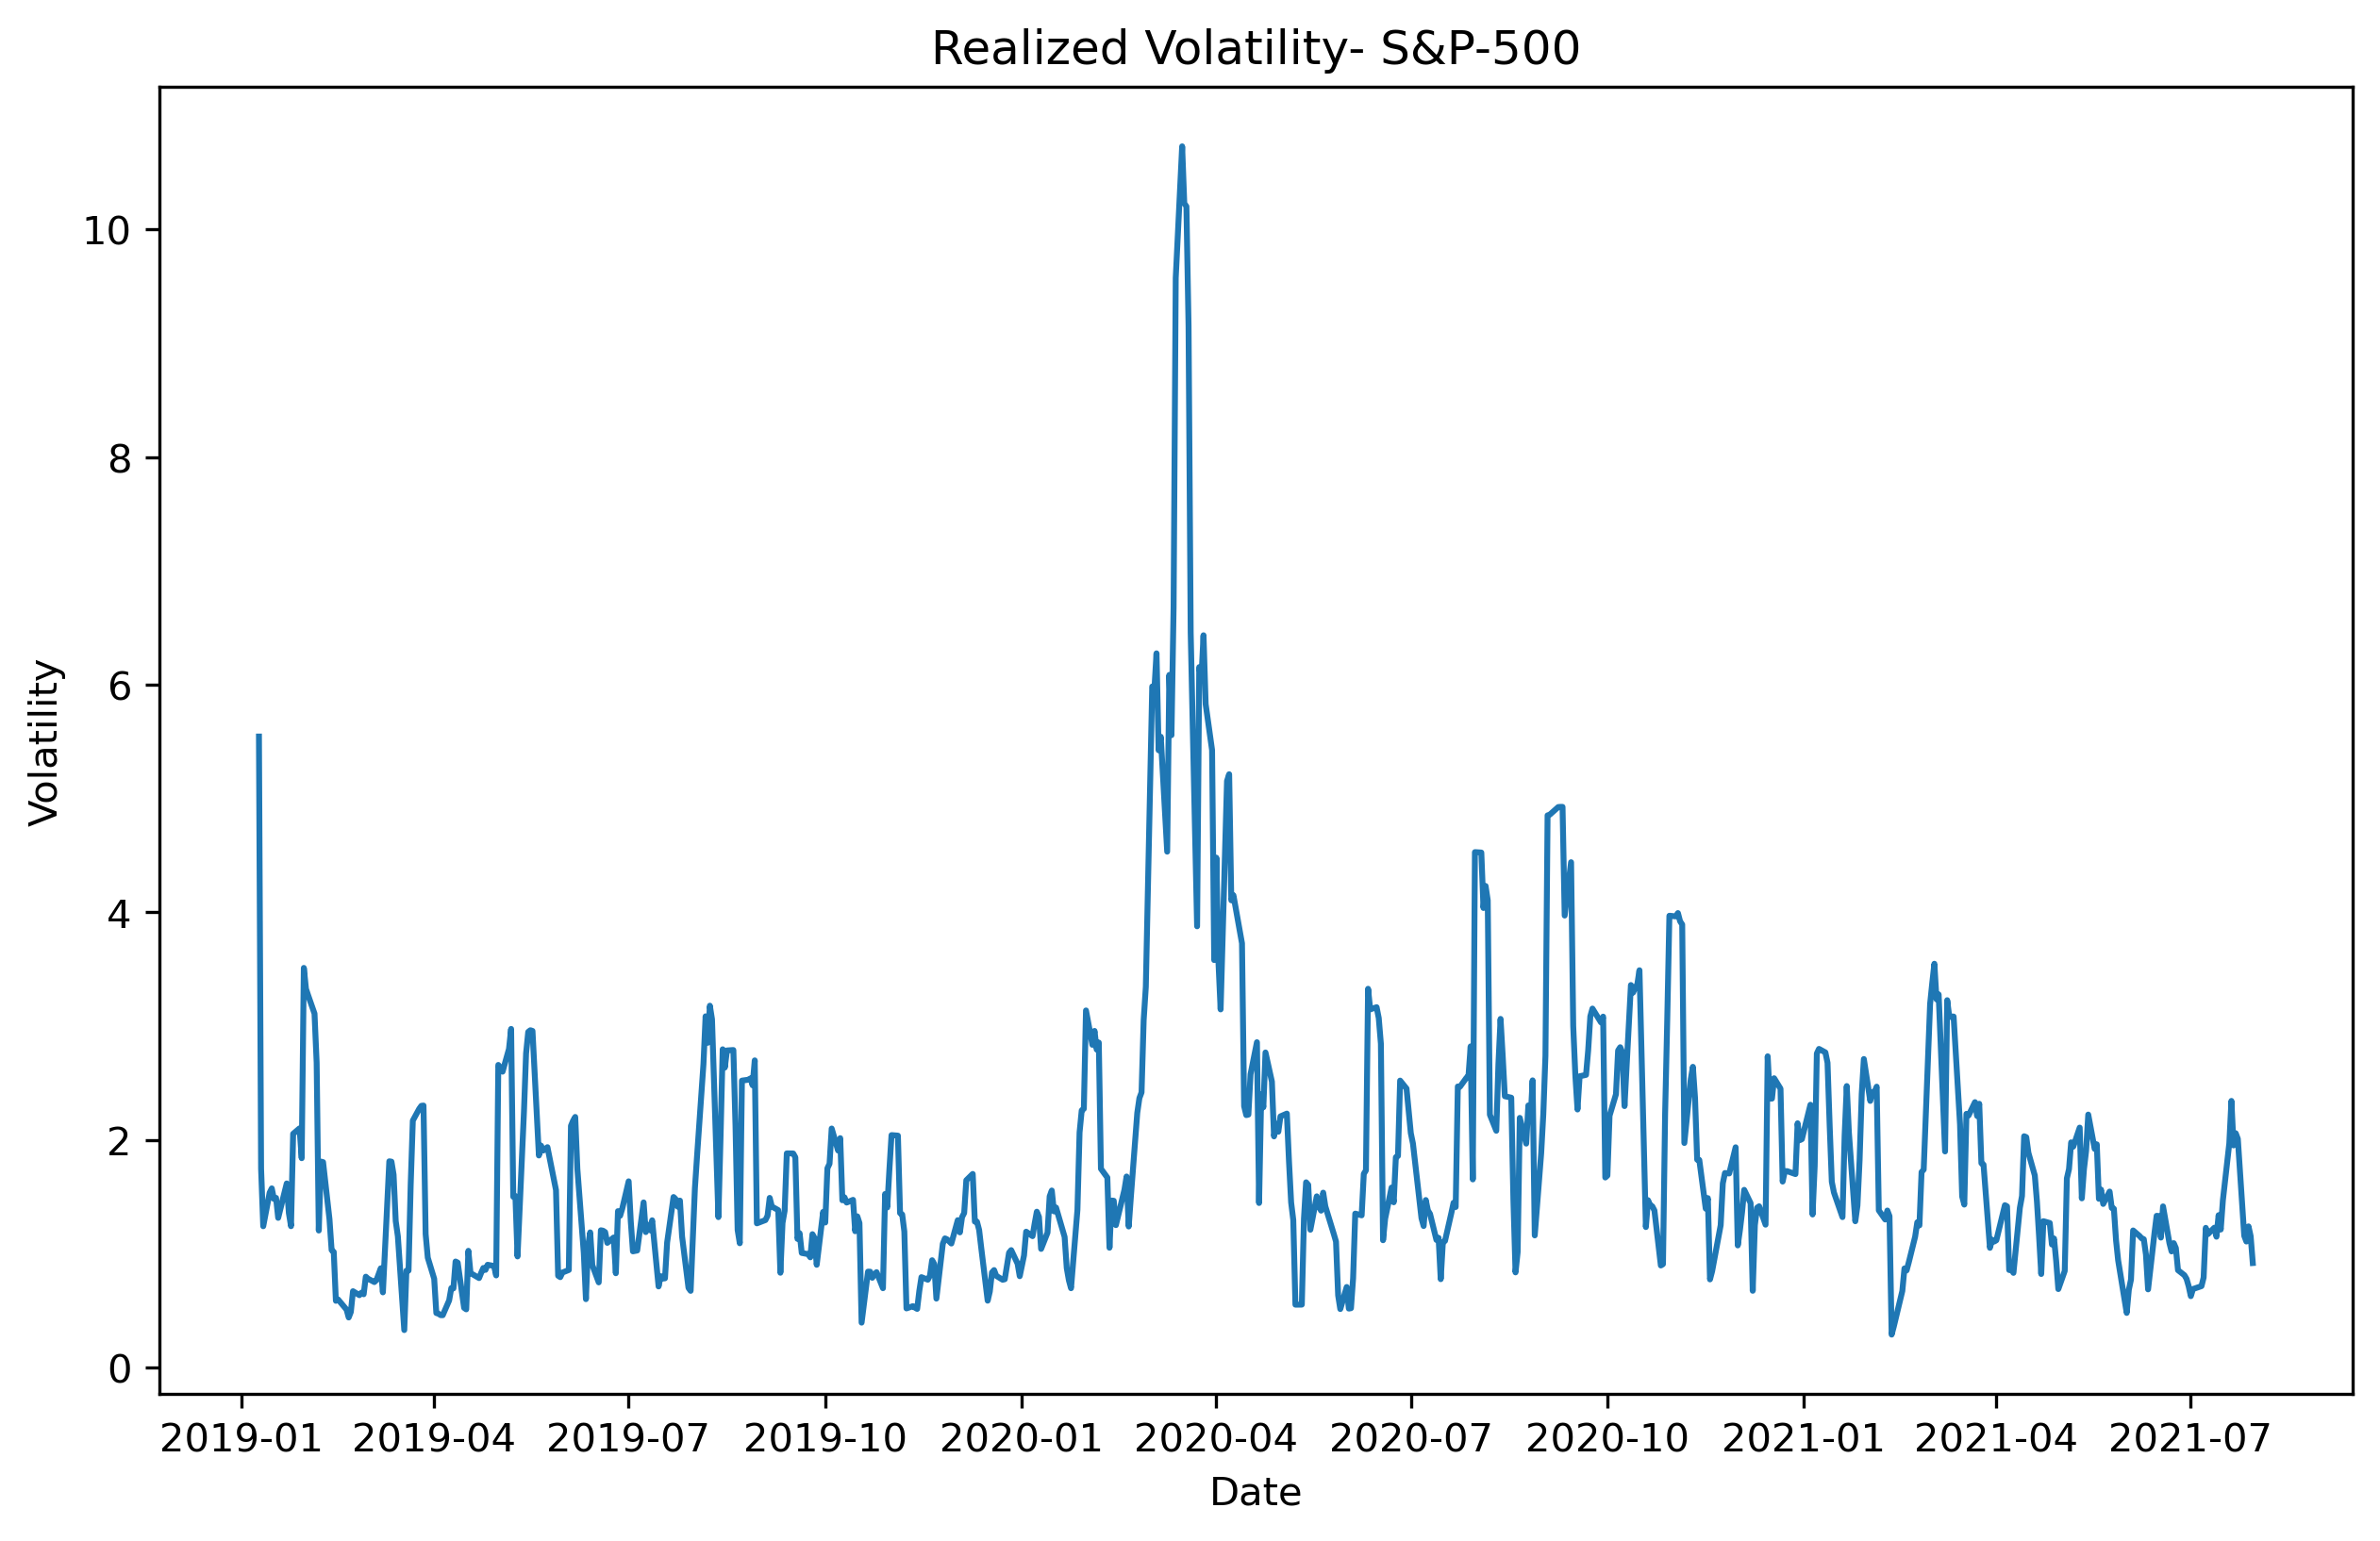

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- S&P-500') 
plt.ylabel('Volatility')
plt.xlabel('Date') 
plt.show()

In [6]:
retv = ret.values

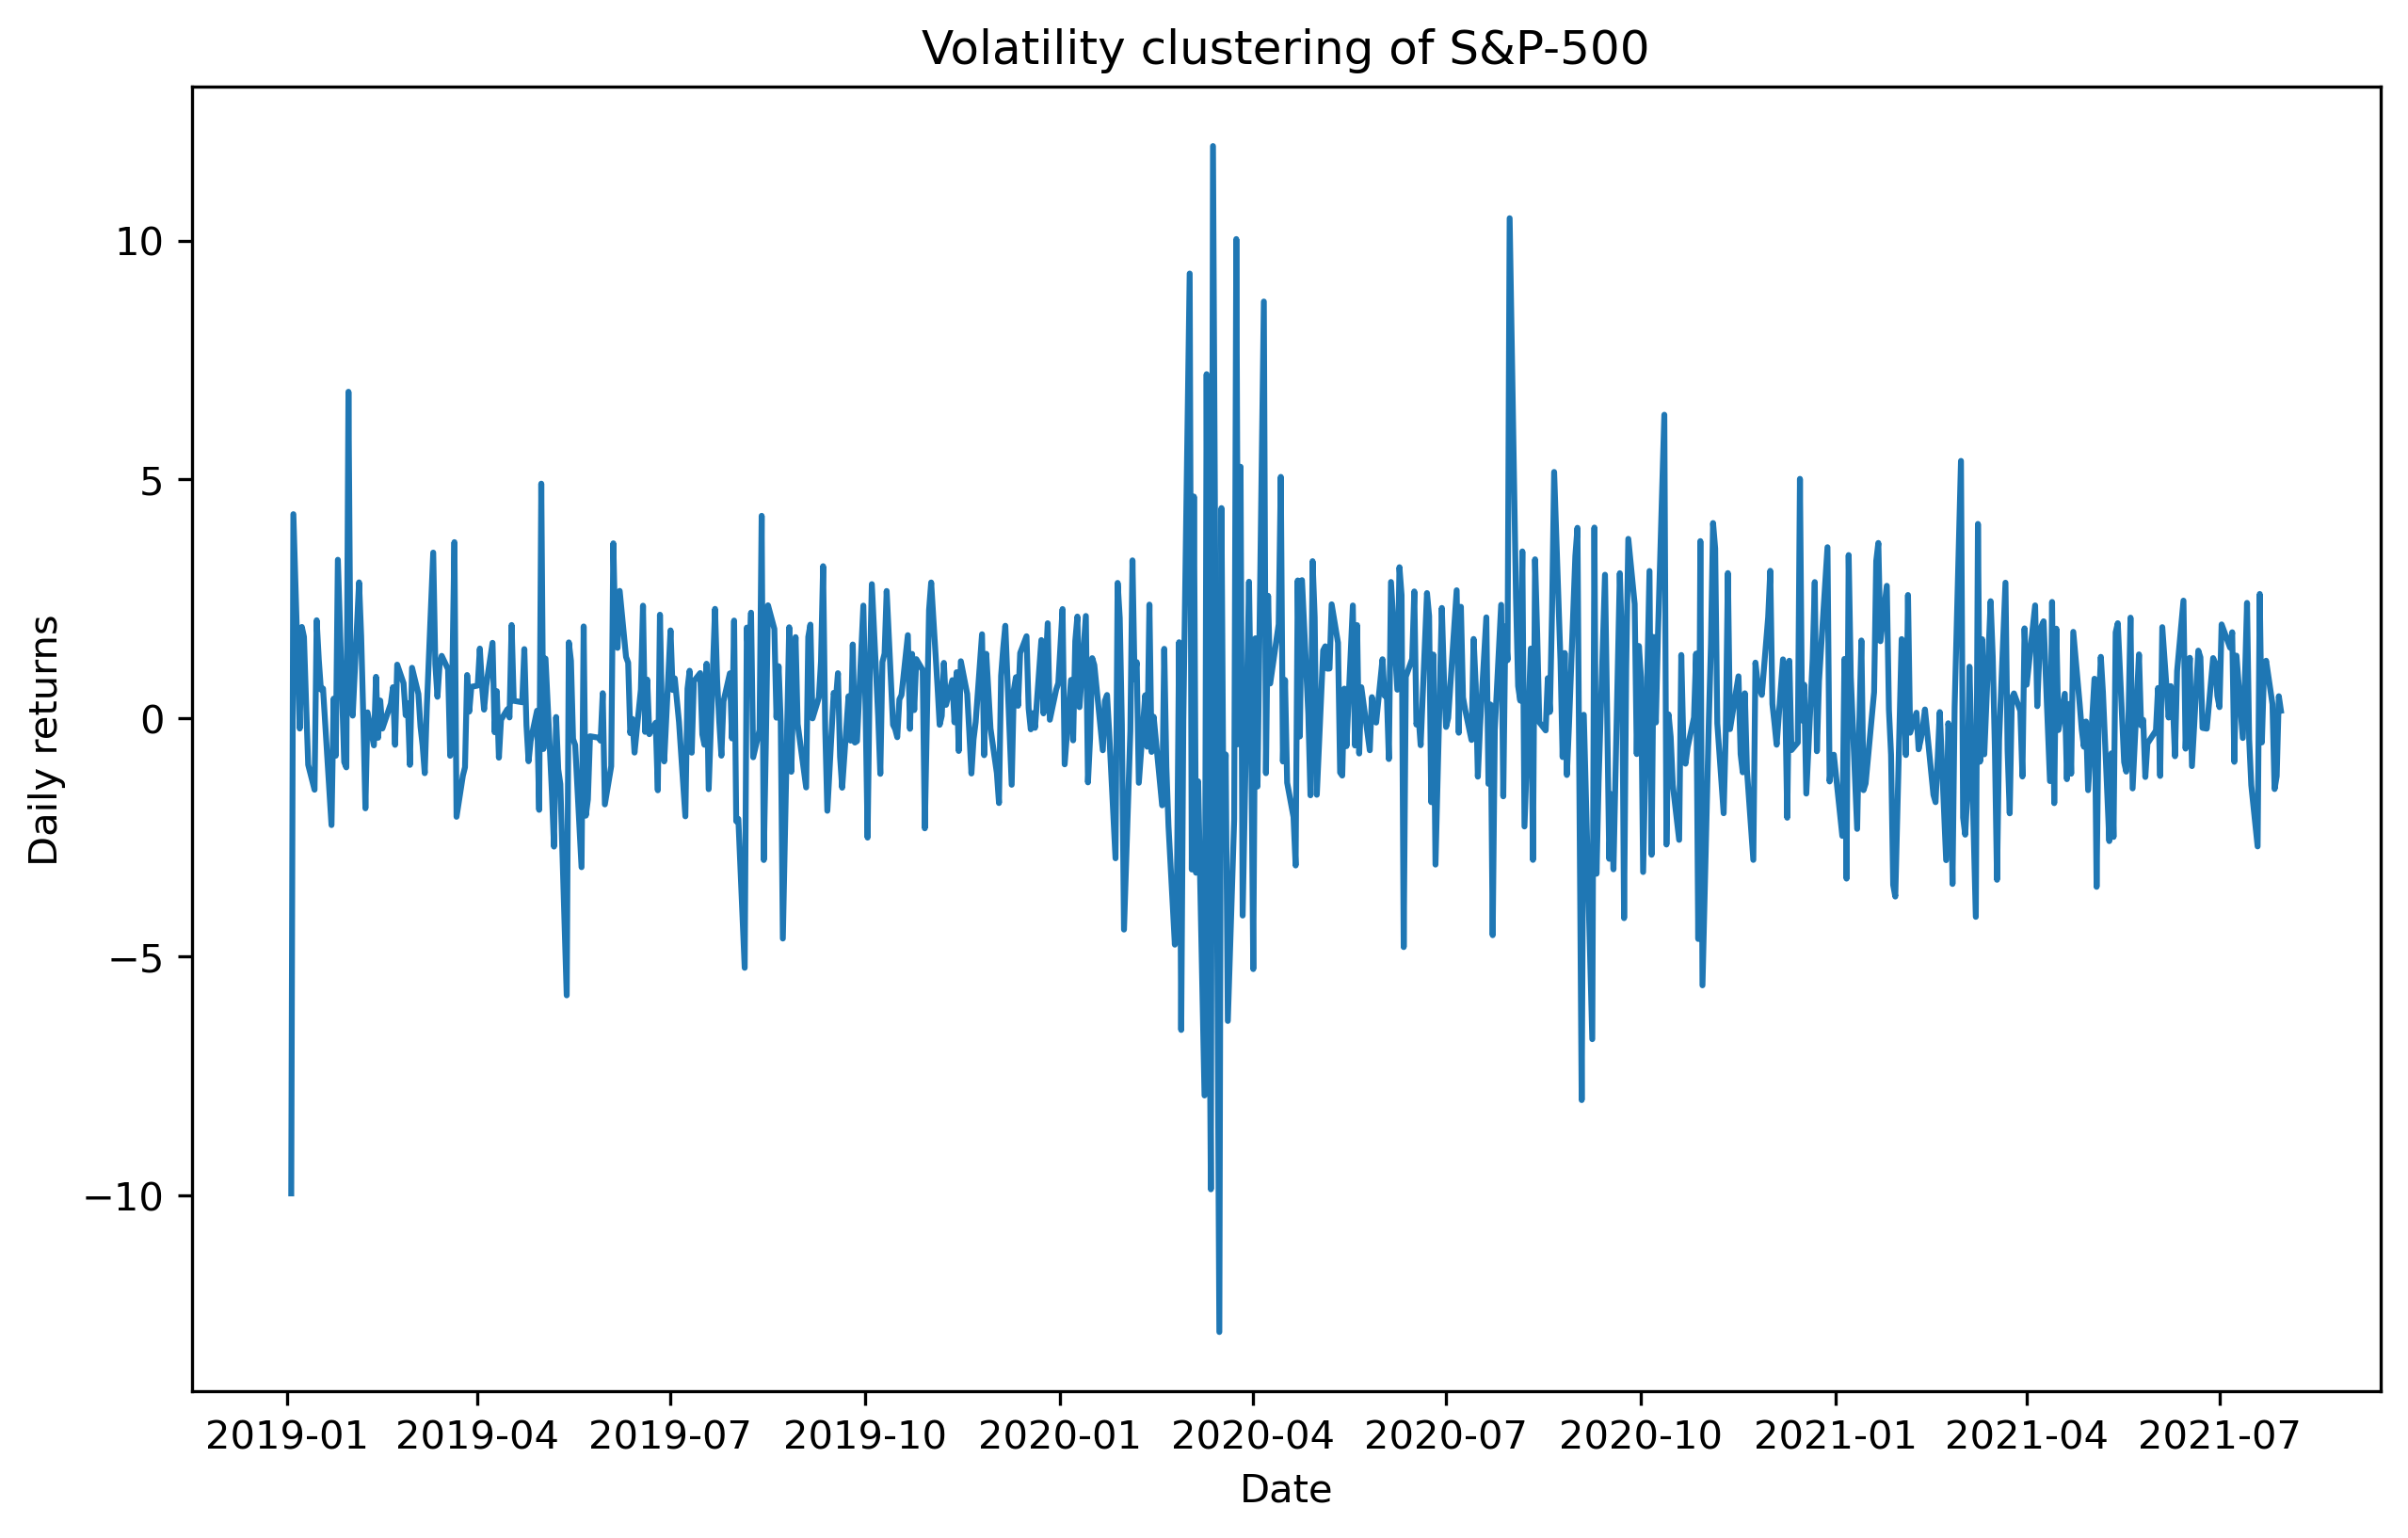

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(s_p500.index[1:], ret)
plt.title('Volatility clustering of S&P-500') 
plt.ylabel('Daily returns')
plt.xlabel('Date') 
plt.show()

## ARCH

In [8]:
n = 252
split_date = ret.iloc[-n:].index

In [9]:
sgm2 = ret.var()
K = ret.kurtosis()
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 * 
                             (3.0 * sgm2 - K) * K)) / (6 * K)
omega = (1 - alpha) * sgm2
initial_parameters = [alpha, omega]
omega, alpha

(nan, nan)

In [10]:
@jit(nopython=True, parallel=True)
def arch_likelihood(initial_parameters, retv):
    omega = abs(initial_parameters[0])
    alpha = abs(initial_parameters[1])
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 
    logliks = np.sum(0.5 * (np.log(sigma2)+retv ** 2 / sigma2))
    return logliks


In [11]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

nan

In [12]:
def opt_params(x0, retv):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args = (retv),
                              method='Nelder-Mead', 
                              options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'
          .format(''.join(['-'] * 28), opt_result))
    print('\nResulting params = {}'.format(params))
    return params

In [13]:
params = opt_params(initial_parameters, retv)


Results of Nelder-Mead minimization
----------------------------
 final_simplex: (array([[nan, nan],
       [nan, nan],
       [nan, nan]]), array([nan, nan, nan]))
           fun: nan
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 19999
           nit: 5000
        status: 2
       success: False
             x: array([nan, nan])

Resulting params = [nan nan]


In [14]:
def arch_apply(ret):
        omega = params[0]
        alpha = params[1]
        T = len(ret)
        sigma2_arch = np.zeros(T + 1)
        sigma2_arch[0] = np.var(ret)
        for t in range(1, T):
            sigma2_arch[t] = omega + alpha * ret[t - 1] ** 2
        return sigma2_arch

In [15]:
sigma2_arch = arch_apply(ret)

In [16]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                       ARCH   Log-Likelihood:               -1417.10
Distribution:                  Normal   AIC:                           2838.21
Method:            Maximum Likelihood   BIC:                           2847.16
                                        No. Observations:                  649
Date:                Mon, Oct 31 2022   Df Residuals:                      649
Time:                        22:24:25   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.7701      0.454      8.304  1.004e-16   [  2.88

In [17]:
bic_arch = []

for p in range(1, 5):
        arch = arch_model(ret, mean='zero', vol='ARCH', p=p)\
                .fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param)\
        .fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                       ARCH   Log-Likelihood:               -1364.39
Distribution:                  Normal   AIC:                           2738.79
Method:            Maximum Likelihood   BIC:                           2761.16
                                        No. Observations:                  649
Date:                Mon, Oct 31 2022   Df Residuals:                      649
Time:                        22:24:26   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.6949      0.285      5.940  2.844e-09    [  

In [18]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100, 
                        np.sqrt(forecast_arch\
                        .variance.iloc[-len(split_date):] 
                        / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.2011


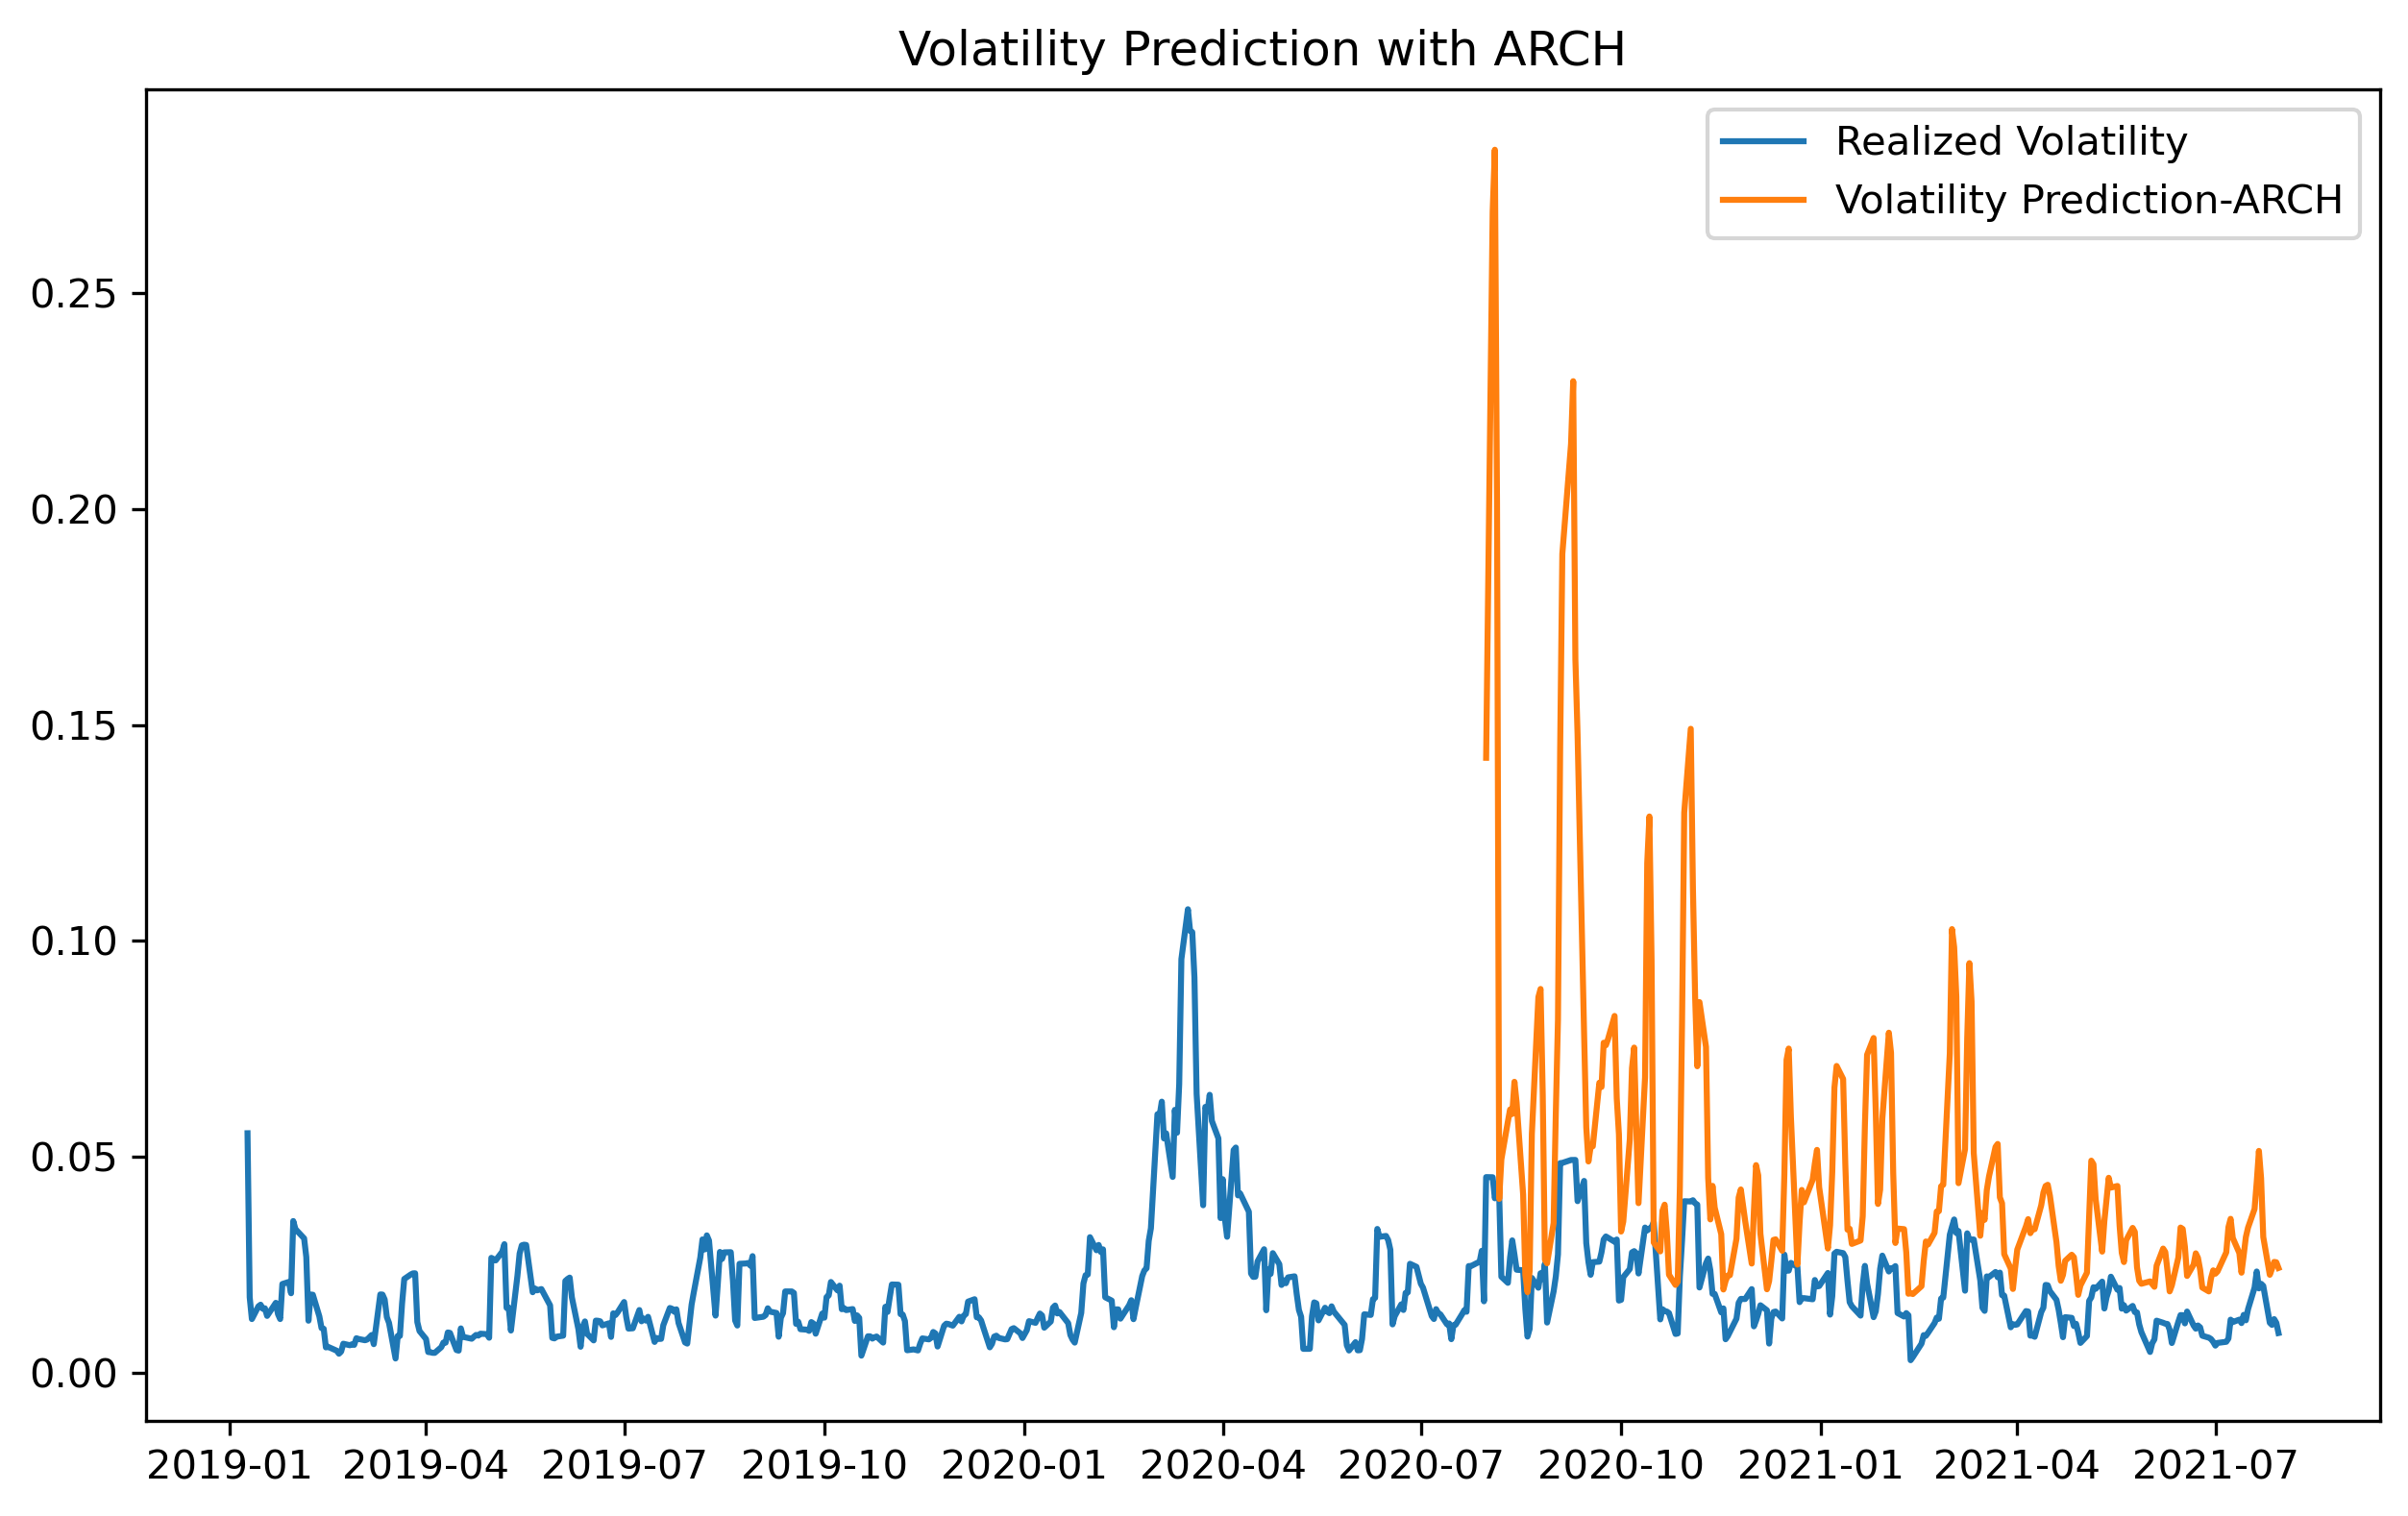

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

## GARCH

In [20]:
a0 = 0.0001
sgm2 = ret.var()
K = ret.kurtosis()
h = 1 - alpha / sgm2
alpha = np.sqrt(K * (1 - h ** 2) / (2.0 * (K + 3)))
beta = np.abs(h - omega)
omega = (1 - omega) * sgm2
initial_parameters = np.array([omega, alpha, beta])
print('Initial parameters for omega, alpha, and beta are \n{}\n{}\n{}'
      .format(omega, alpha, beta))

Initial parameters for omega, alpha, and beta are 
nan
nan
nan


In [21]:
retv = ret.values

In [22]:
@jit(nopython=True, parallel=True)
def garch_likelihood(initial_parameters, retv):
    omega = initial_parameters[0]
    alpha = initial_parameters[1]
    beta = initial_parameters[2]
    T =  len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 + beta * sigma2[t-1]
    logliks = np.sum(0.5 * (np.log(sigma2) + retv ** 2 / sigma2))
    return logliks

In [23]:
logliks = garch_likelihood(initial_parameters, retv)
print('The Log likelihood  is {:.4f}'.format(logliks))

The Log likelihood  is nan


In [24]:
def garch_constraint(initial_parameters):  
    alpha = initial_parameters[0]
    gamma = initial_parameters[1]
    beta = initial_parameters[2]
    return np.array([1 - alpha - beta])

In [25]:
bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

In [26]:
def opt_paramsG(initial_parameters, retv):
    opt_result = opt.minimize(garch_likelihood, 
                              x0=initial_parameters,
                              constraints=np.array([1 - alpha - beta]), 
                              bounds=bounds, args = (retv),
                              method='Nelder-Mead',
                              options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'\
          .format('-' * 35, opt_result))
    print('-' * 35)
    print('\nResulting parameters = {}'.format(params))
    return params

In [27]:
params = opt_paramsG(initial_parameters, retv)


Results of Nelder-Mead minimization
-----------------------------------
 final_simplex: (array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]]), array([nan, nan, nan, nan]))
           fun: nan
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 24999
           nit: 5000
        status: 2
       success: False
             x: array([nan, nan, nan])
-----------------------------------

Resulting parameters = [nan nan nan]


In [28]:
def garch_apply(ret):
        omega = params[0]
        alpha = params[1]
        beta = params[2]
        T = len(ret)
        sigma2 = np.zeros(T + 1)
        sigma2[0] = np.var(ret)
        for t in range(1, T):
            sigma2[t] = omega + alpha * ret[t - 1] ** 2 +\
                        beta * sigma2[t-1]
        return sigma2

In [29]:
garch = arch_model(ret, mean='zero', vol='GARCH', p=1, o=0, q=1)\
        .fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -1355.71
Distribution:                  Normal   AIC:                           2717.43
Method:            Maximum Likelihood   BIC:                           2730.85
                                        No. Observations:                  649
Date:                Mon, Oct 31 2022   Df Residuals:                      649
Time:                        22:24:28   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2295  9.310e-02      2.466  1.368e-02 [4.707e-0

In [30]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1])\
        .fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -1355.71
Distribution:                  Normal   AIC:                           2717.43
Method:            Maximum Likelihood   BIC:                           2730.85
                                        No. Observations:                  649
Date:                Mon, Oct 31 2022   Df Residuals:                      649
Time:                        22:24:29   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2295  9.310e-02      2.466  1.368e-02 [4.707e-0

In [31]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                         np.sqrt(forecast_garch\
                         .variance.iloc[-len(split_date):] 
                         / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.1941


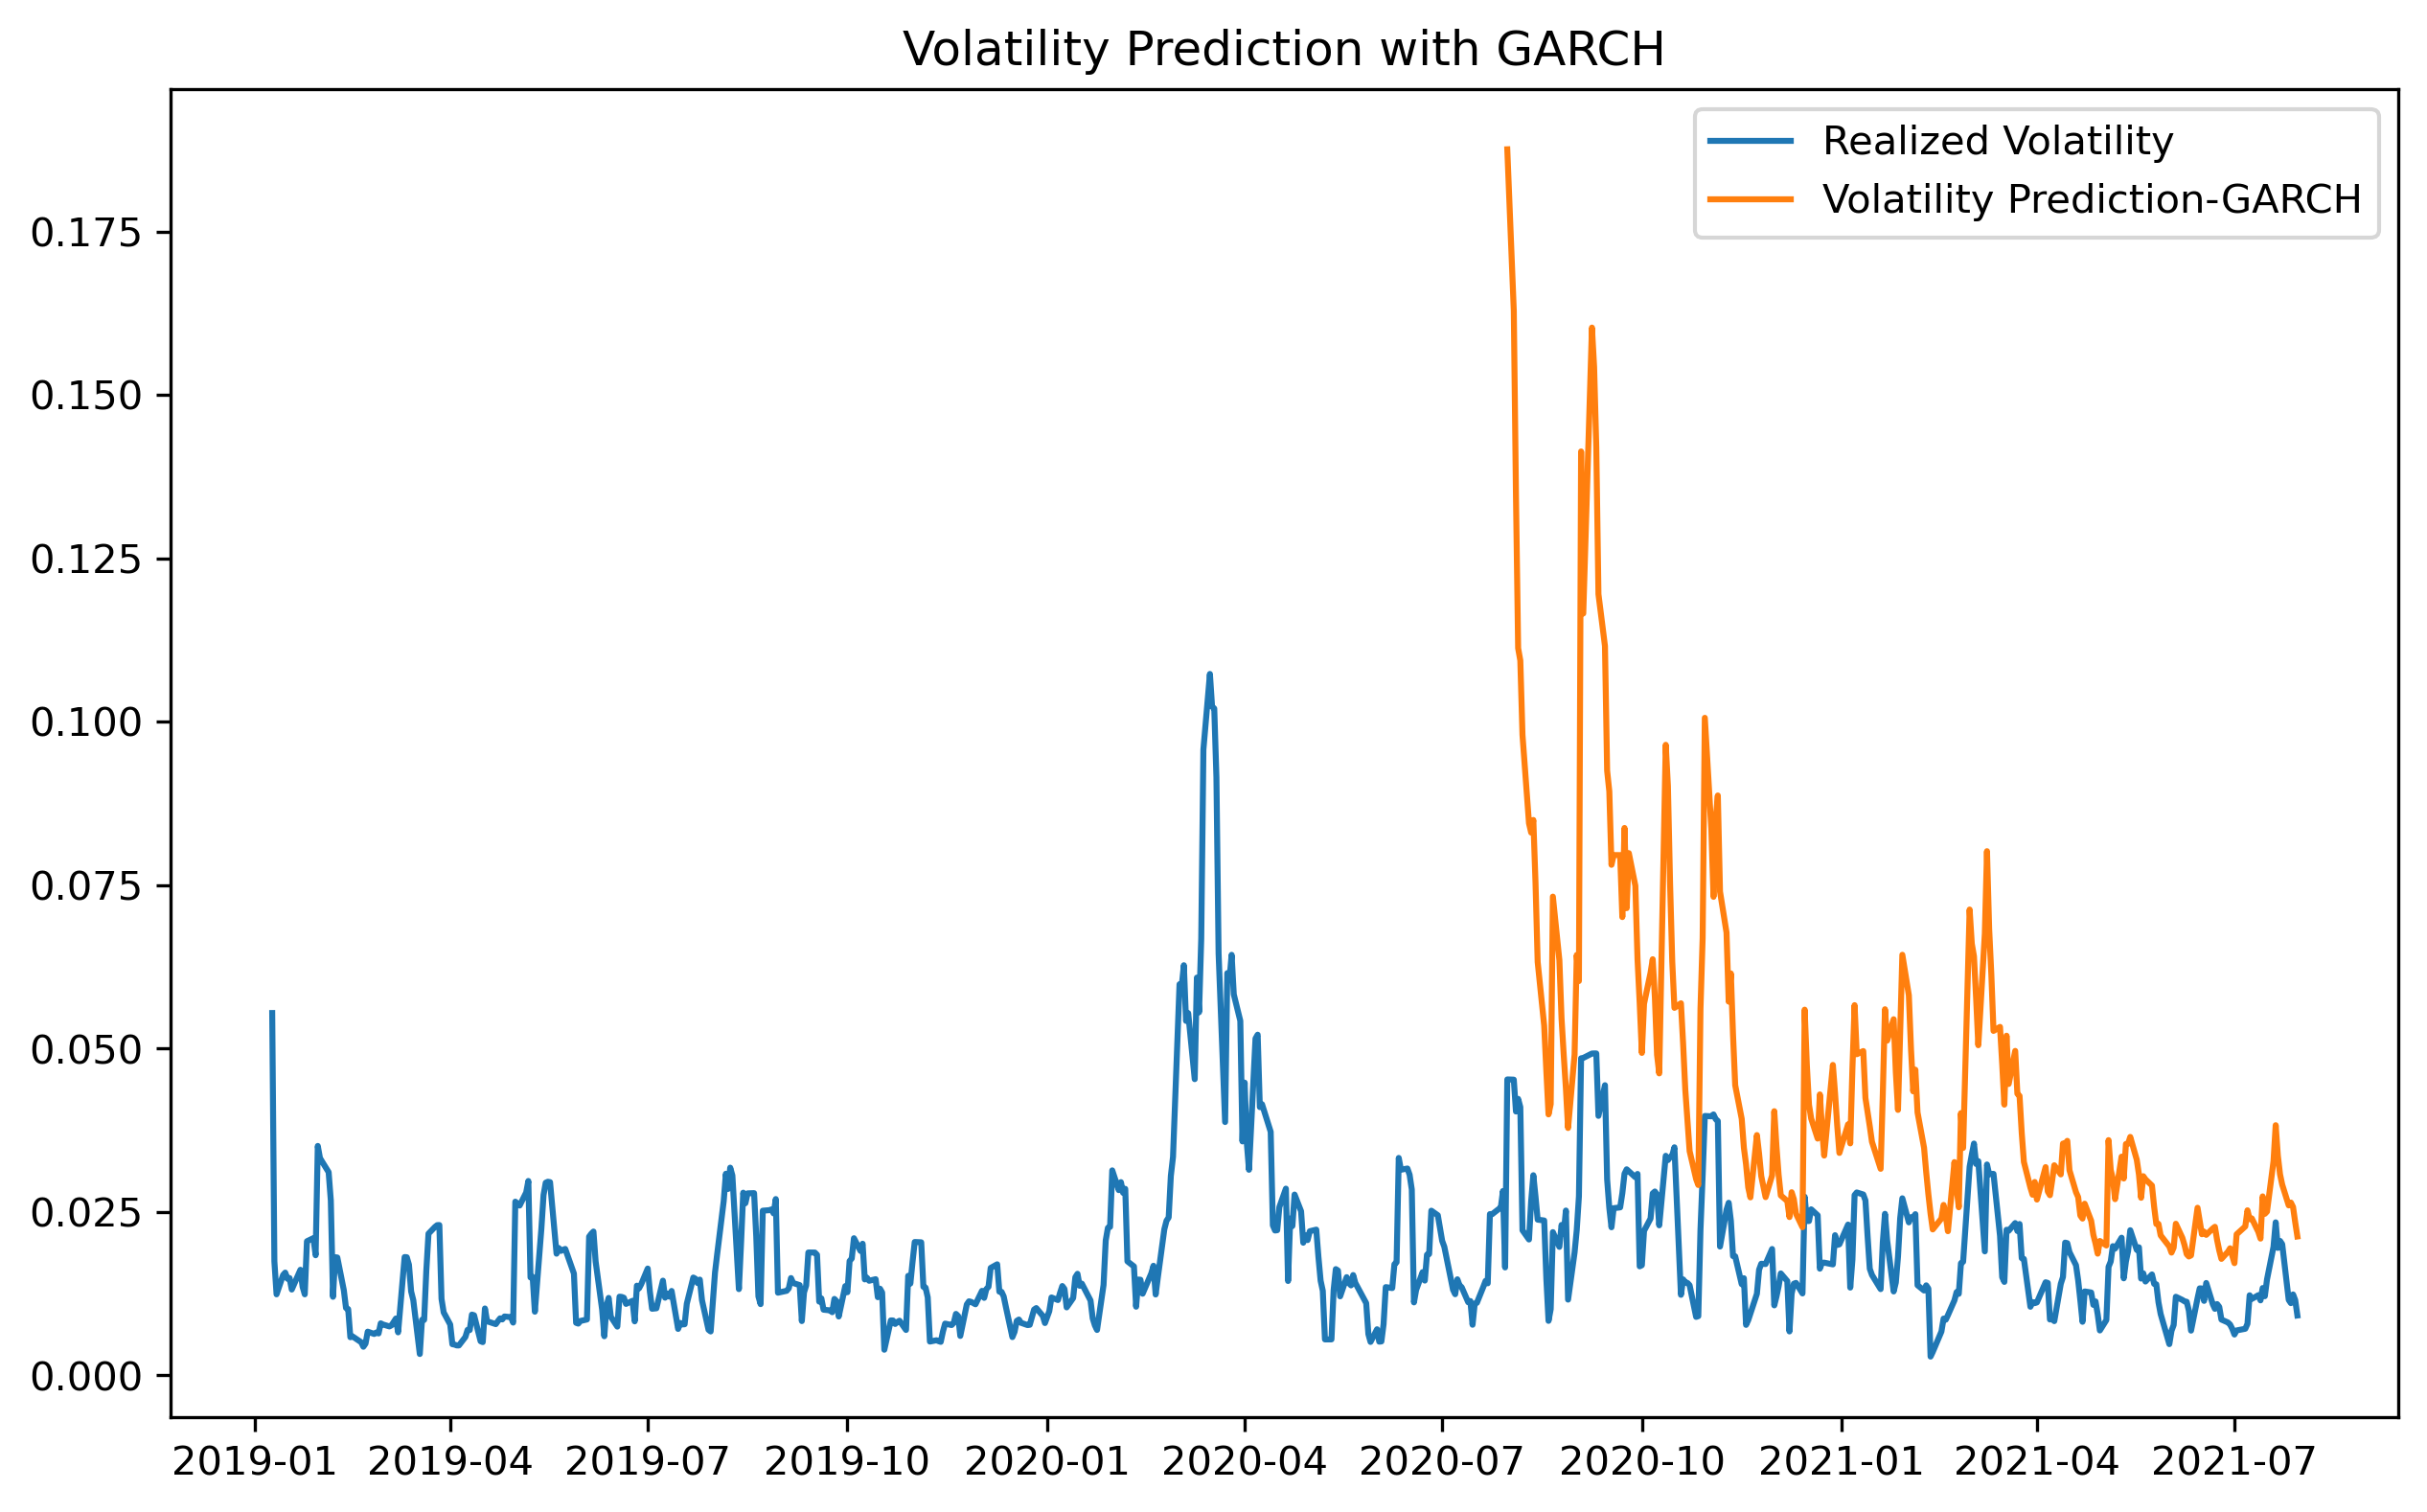

In [32]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

## GJR-GARCH

In [33]:
bic_gjr_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(ret, mean='zero', p=p, o=1, q=q)\
                   .fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
            best_param = p, q
gjrgarch = arch_model(ret,mean='zero', p=best_param[0], o=1,
                      q=best_param[1]).fit(disp='off')
print(gjrgarch.summary())
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1344.89
Distribution:                  Normal   AIC:                           2697.79
Method:            Maximum Likelihood   BIC:                           2715.69
                                        No. Observations:                  649
Date:                Mon, Oct 31 2022   Df Residuals:                      649
Time:                        22:24:30   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2765  9.926e-02      2.786  5.339e-03  [8.19

In [34]:
rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                             np.sqrt(forecast_gjrgarch\
                             .variance.iloc[-len(split_date):]
                             / 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'
      .format(rmse_gjr_garch))

The RMSE value of GJR-GARCH models is 0.1977


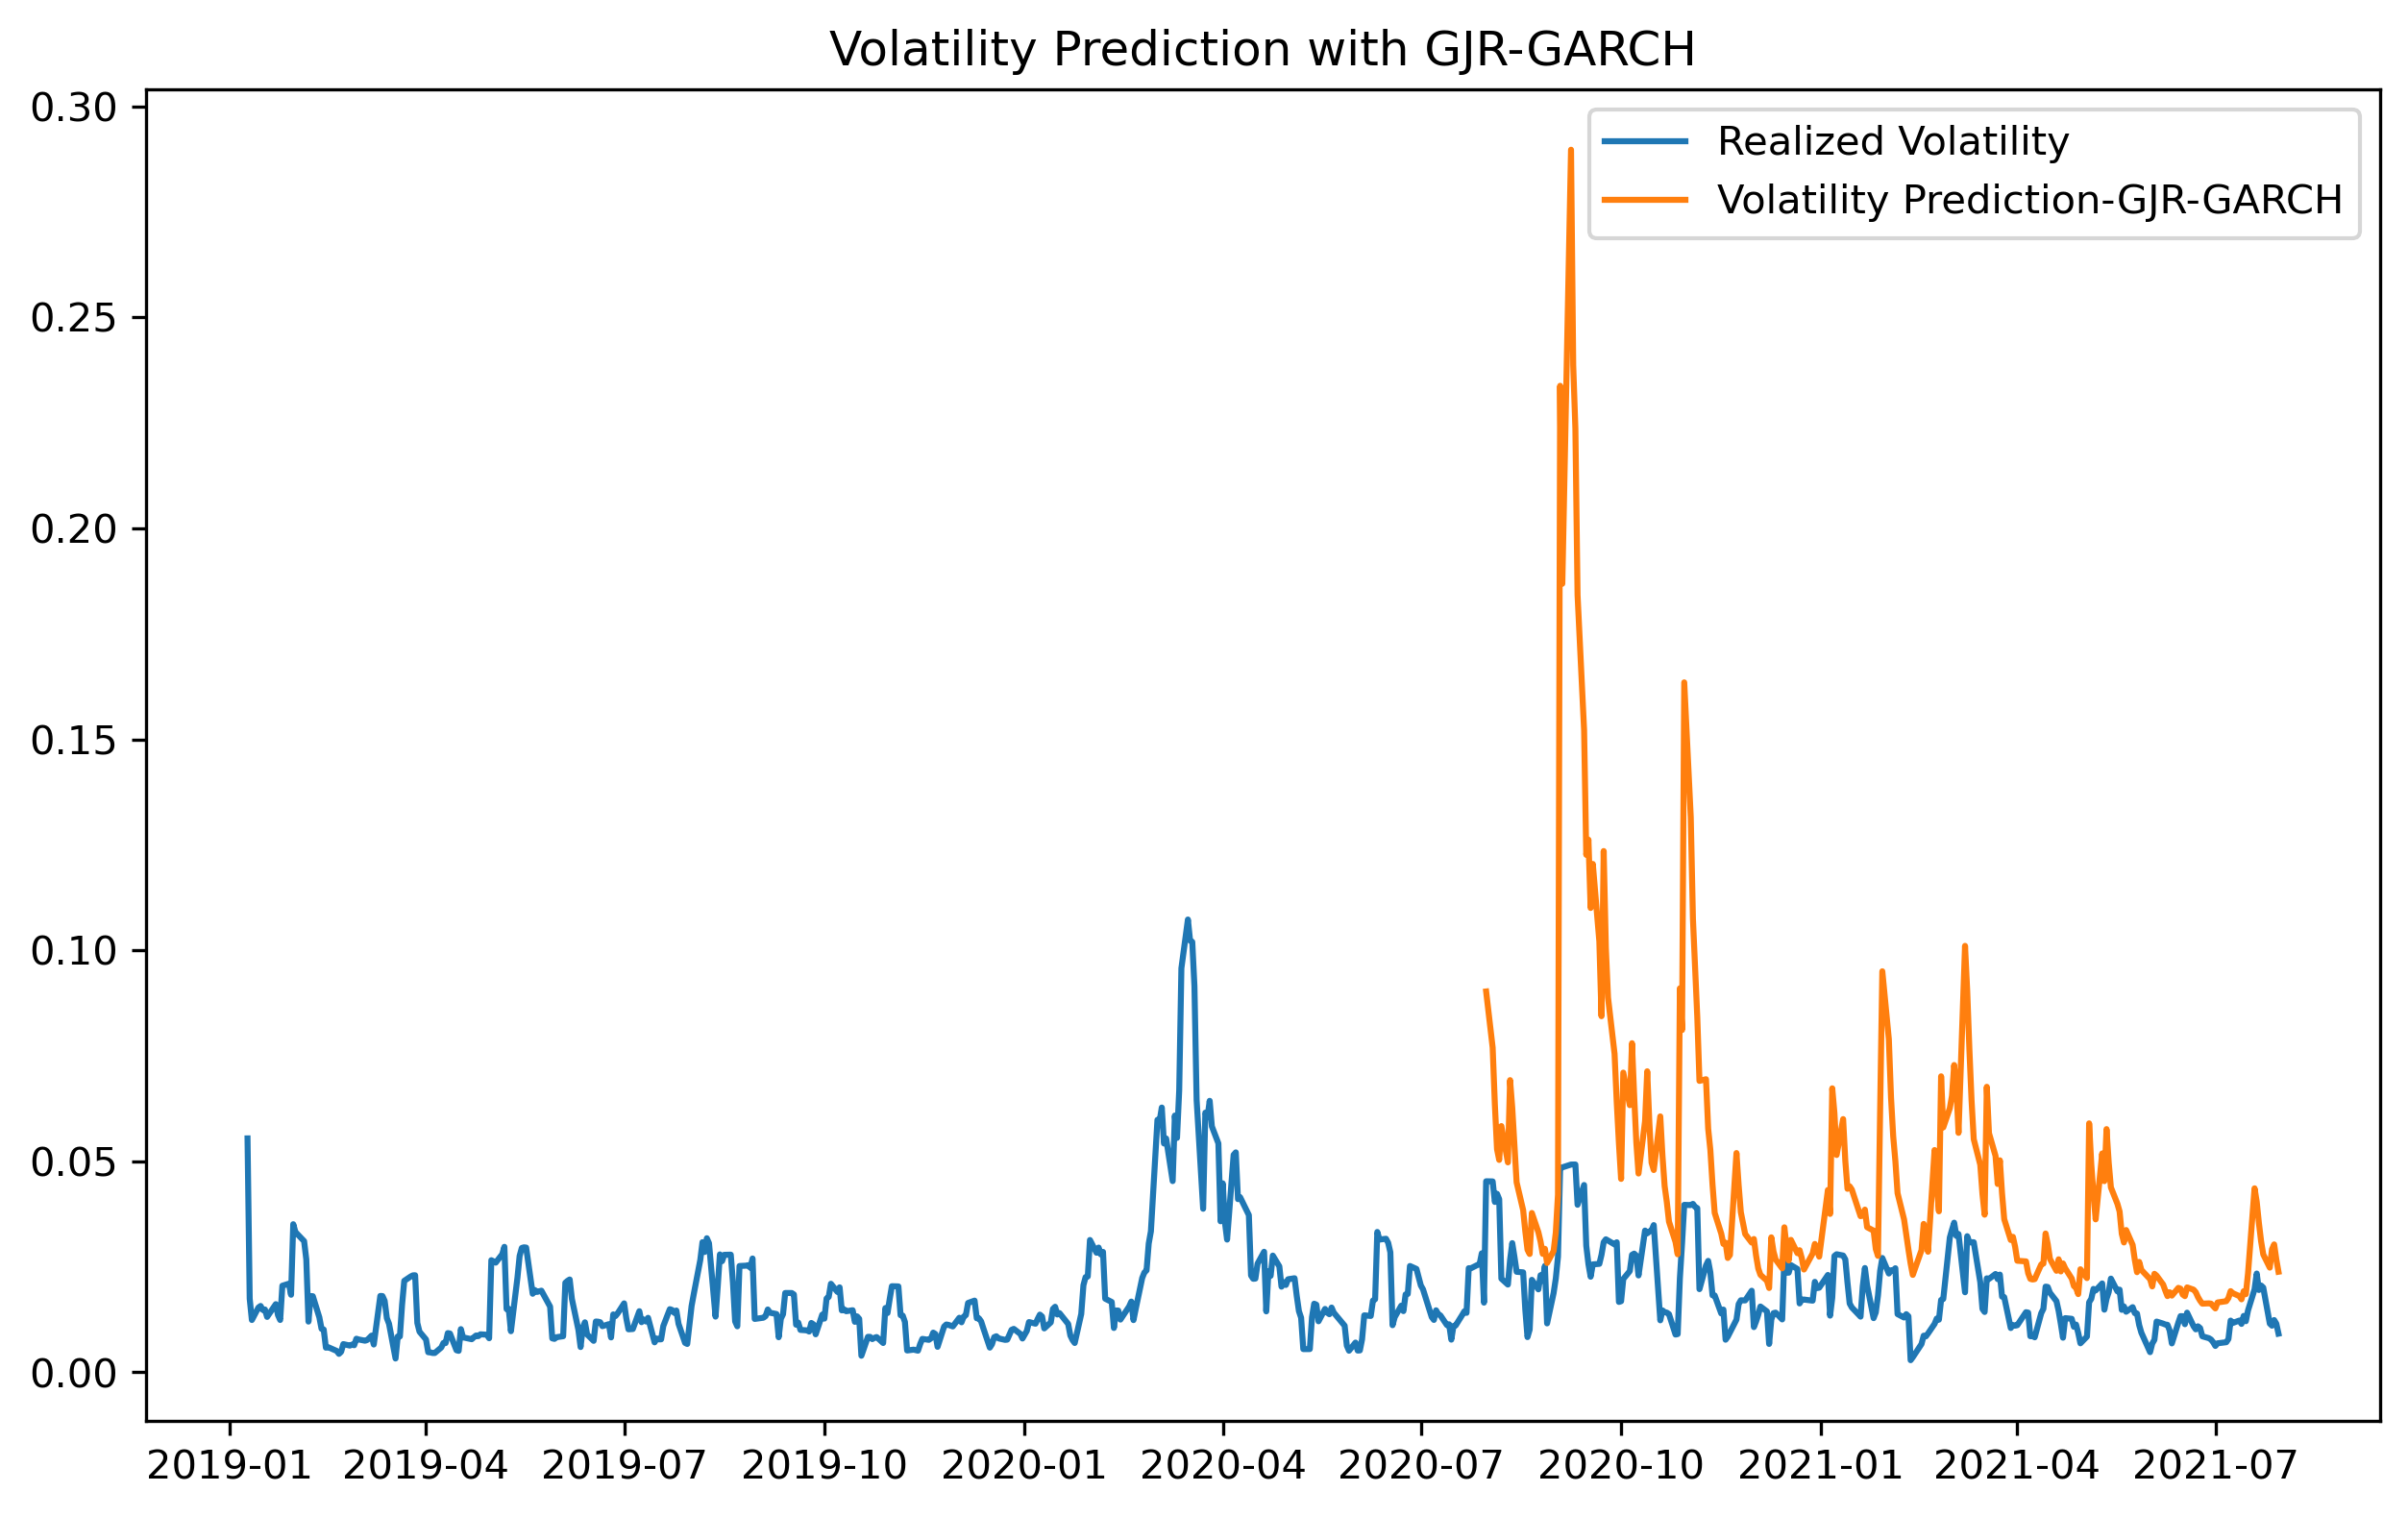

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()

## EGARCH

In [36]:
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(ret, mean='zero', vol='EGARCH', p=p, q=q)\
                 .fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch_model(ret, mean='zero', vol='EGARCH',
                    p=best_param[0], q=best_param[1])\
         .fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                     EGARCH   Log-Likelihood:               -1357.25
Distribution:                  Normal   AIC:                           2720.51
Method:            Maximum Likelihood   BIC:                           2733.93
                                        No. Observations:                  649
Date:                Mon, Oct 31 2022   Df Residuals:                      649
Time:                        22:24:30   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0863  3.812e-02      2.262  2.367e-02 [1.153e-0

In [37]:
rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100,
                          np.sqrt(forecast_egarch.variance\
                          .iloc[-len(split_date):] / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 0.1963


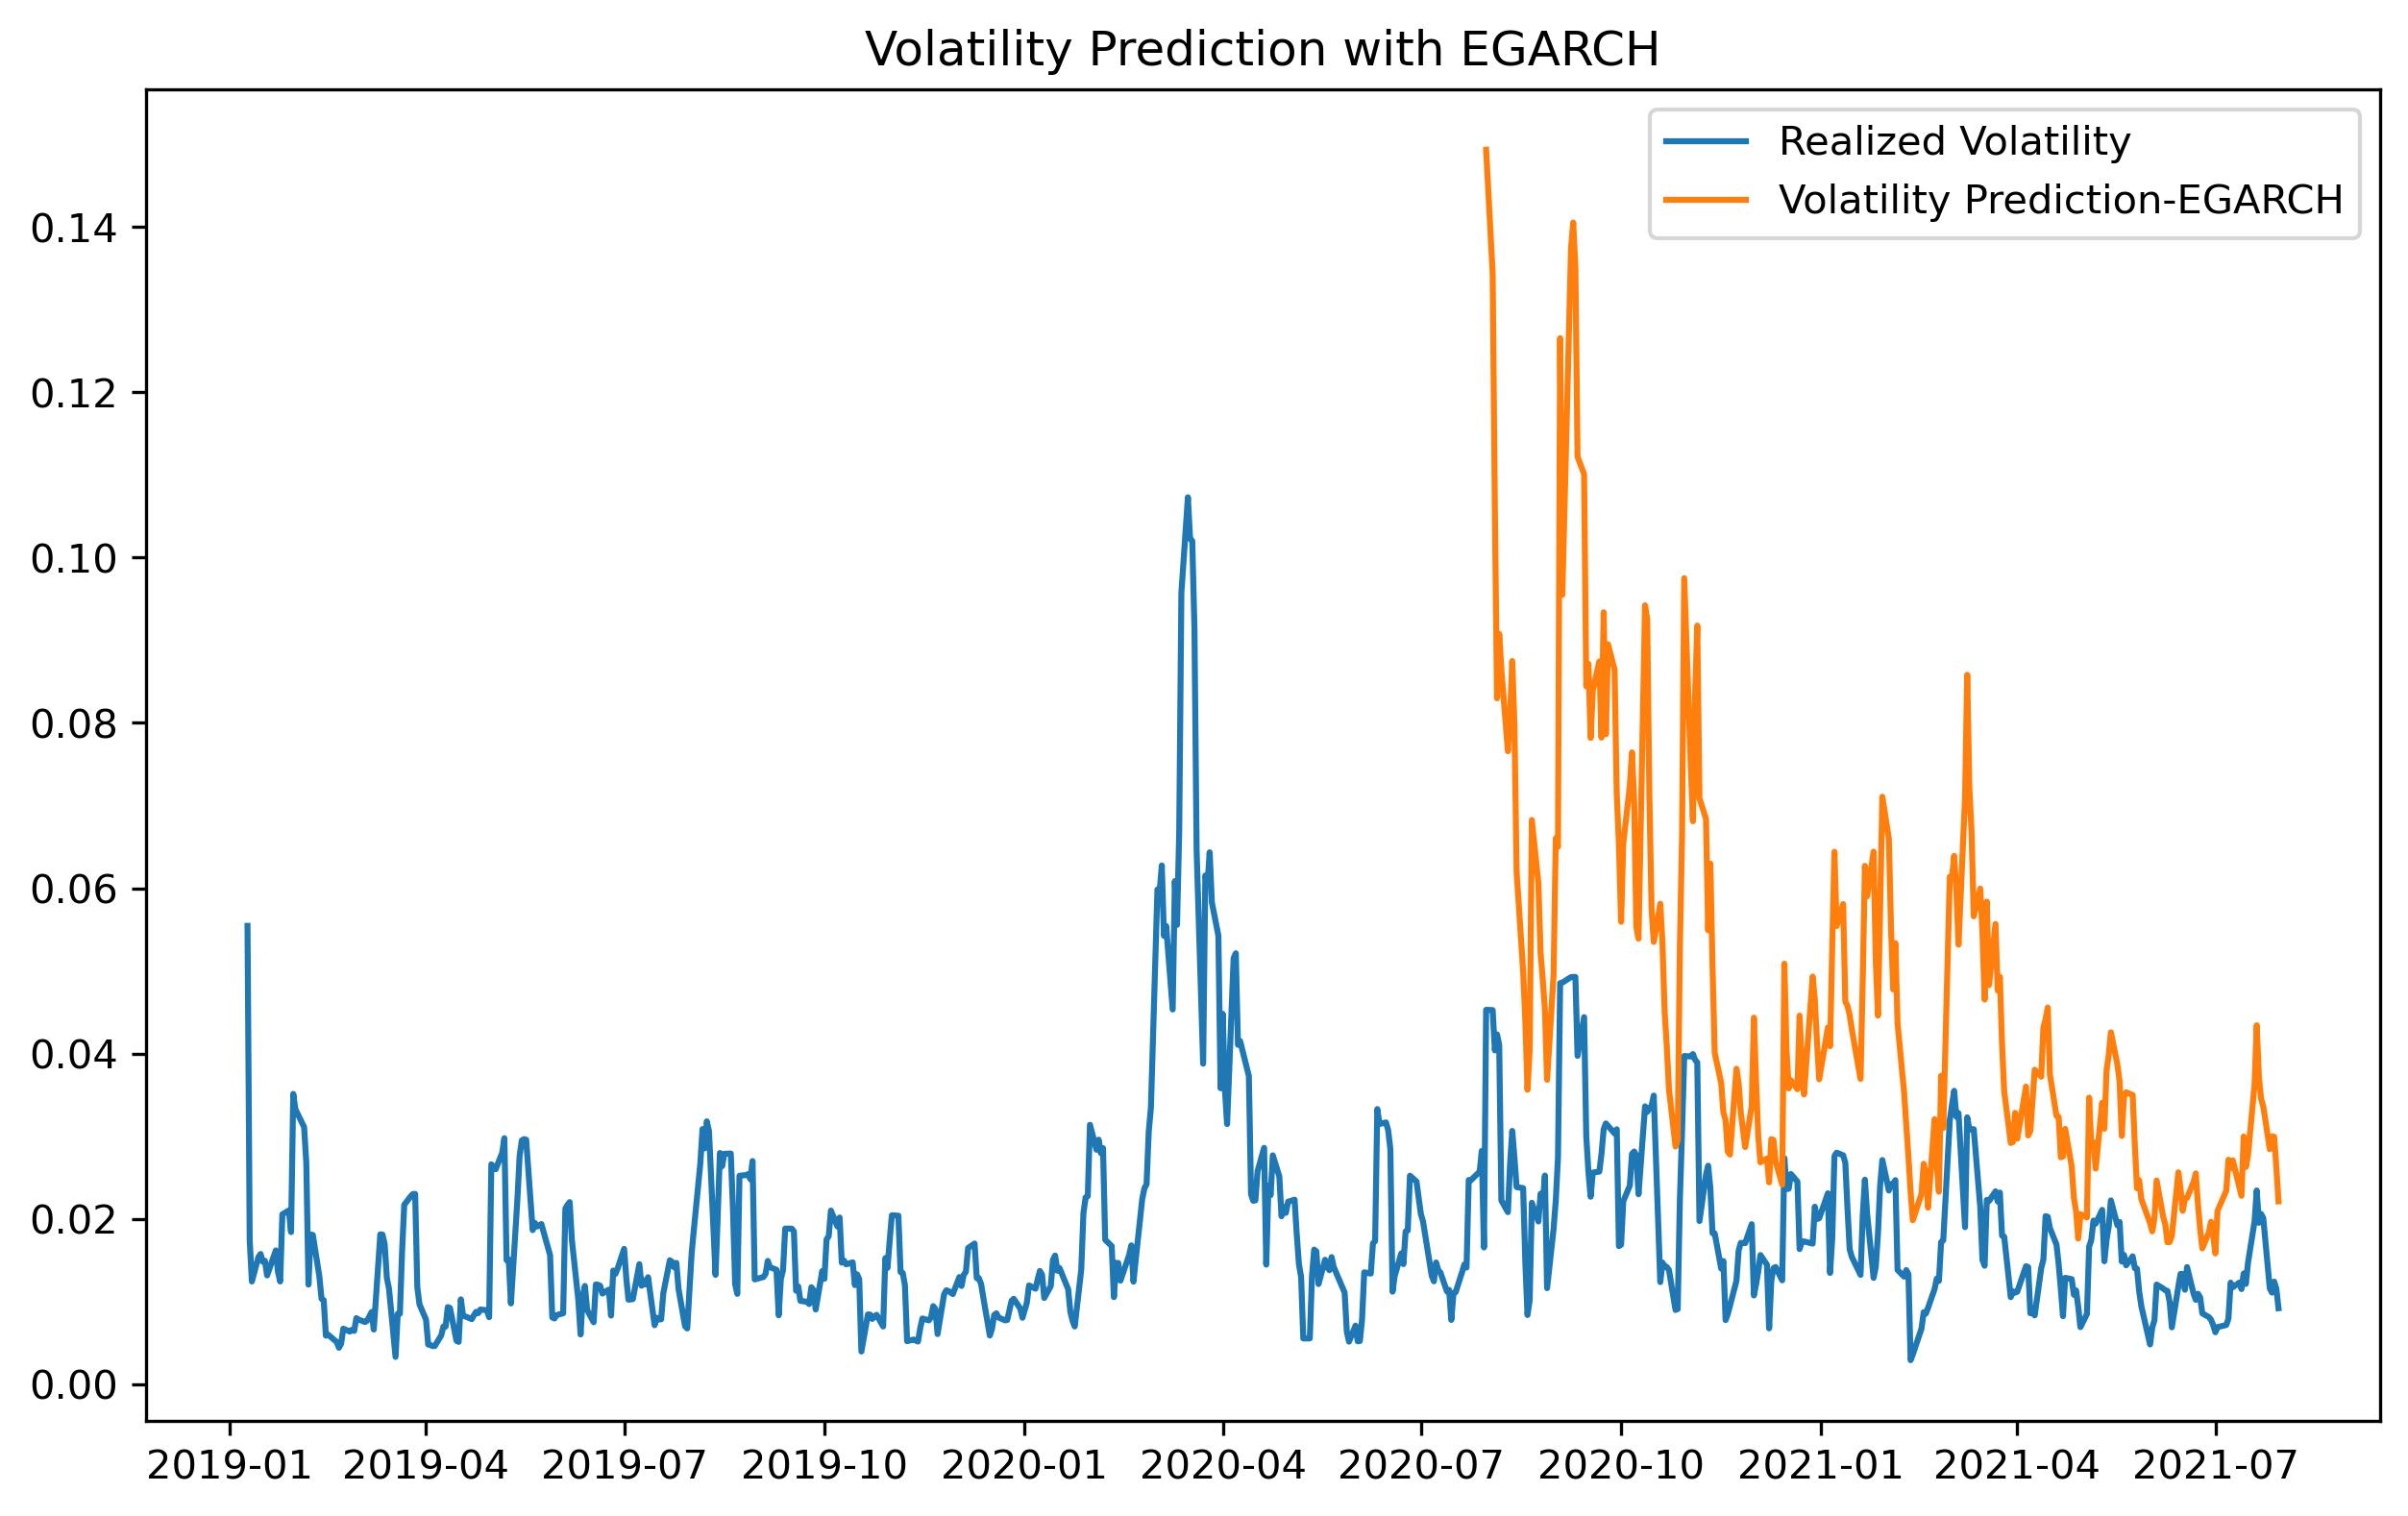

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100,
         label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

## SVR-GARCH

In [39]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [40]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [41]:
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']

In [42]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [43]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

In [44]:
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

### SVR-GARCH-Linear

In [45]:
para_grid = {'gamma': sp_rand(),
             'C': sp_rand(),
             'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

In [46]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [47]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                       predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
      .format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.001686


In [48]:
realized_vol.index = ret.iloc[4:].index

<Figure size 1920x1440 with 0 Axes>

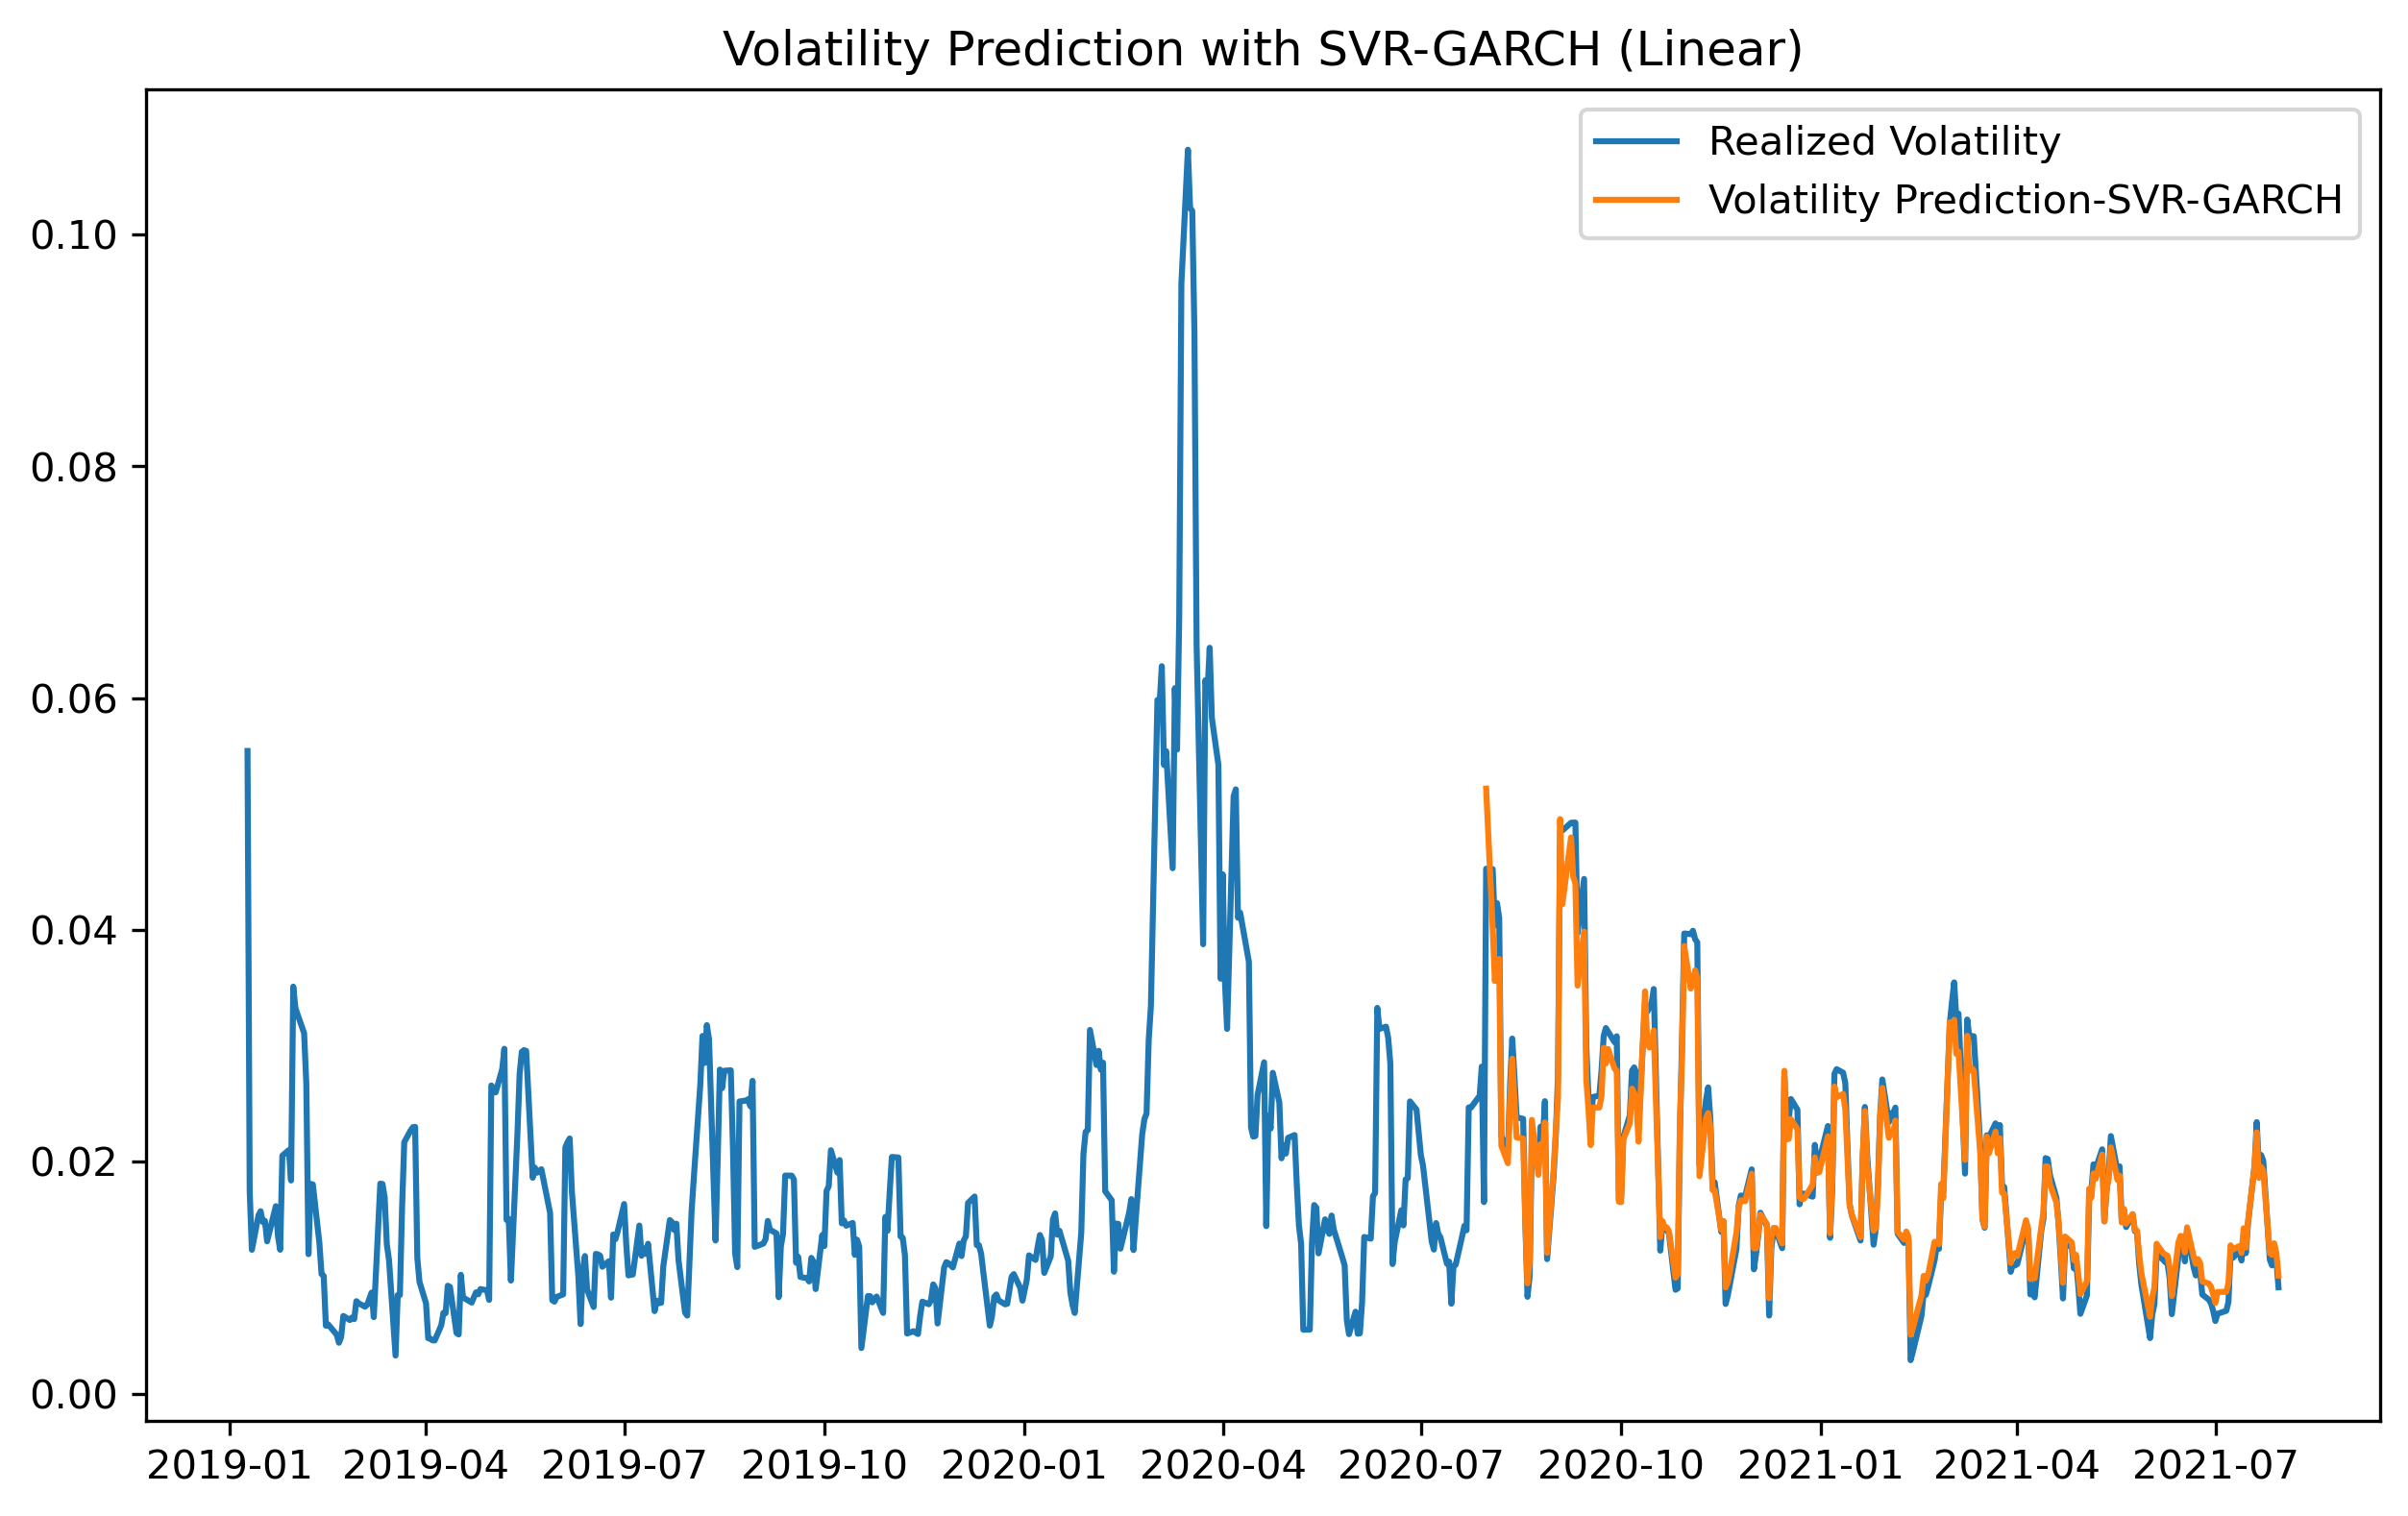

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

### SVR-GARCH RBF

In [50]:
para_grid ={'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

In [51]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [52]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                           predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'
      .format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is  0.002950


<Figure size 1920x1440 with 0 Axes>

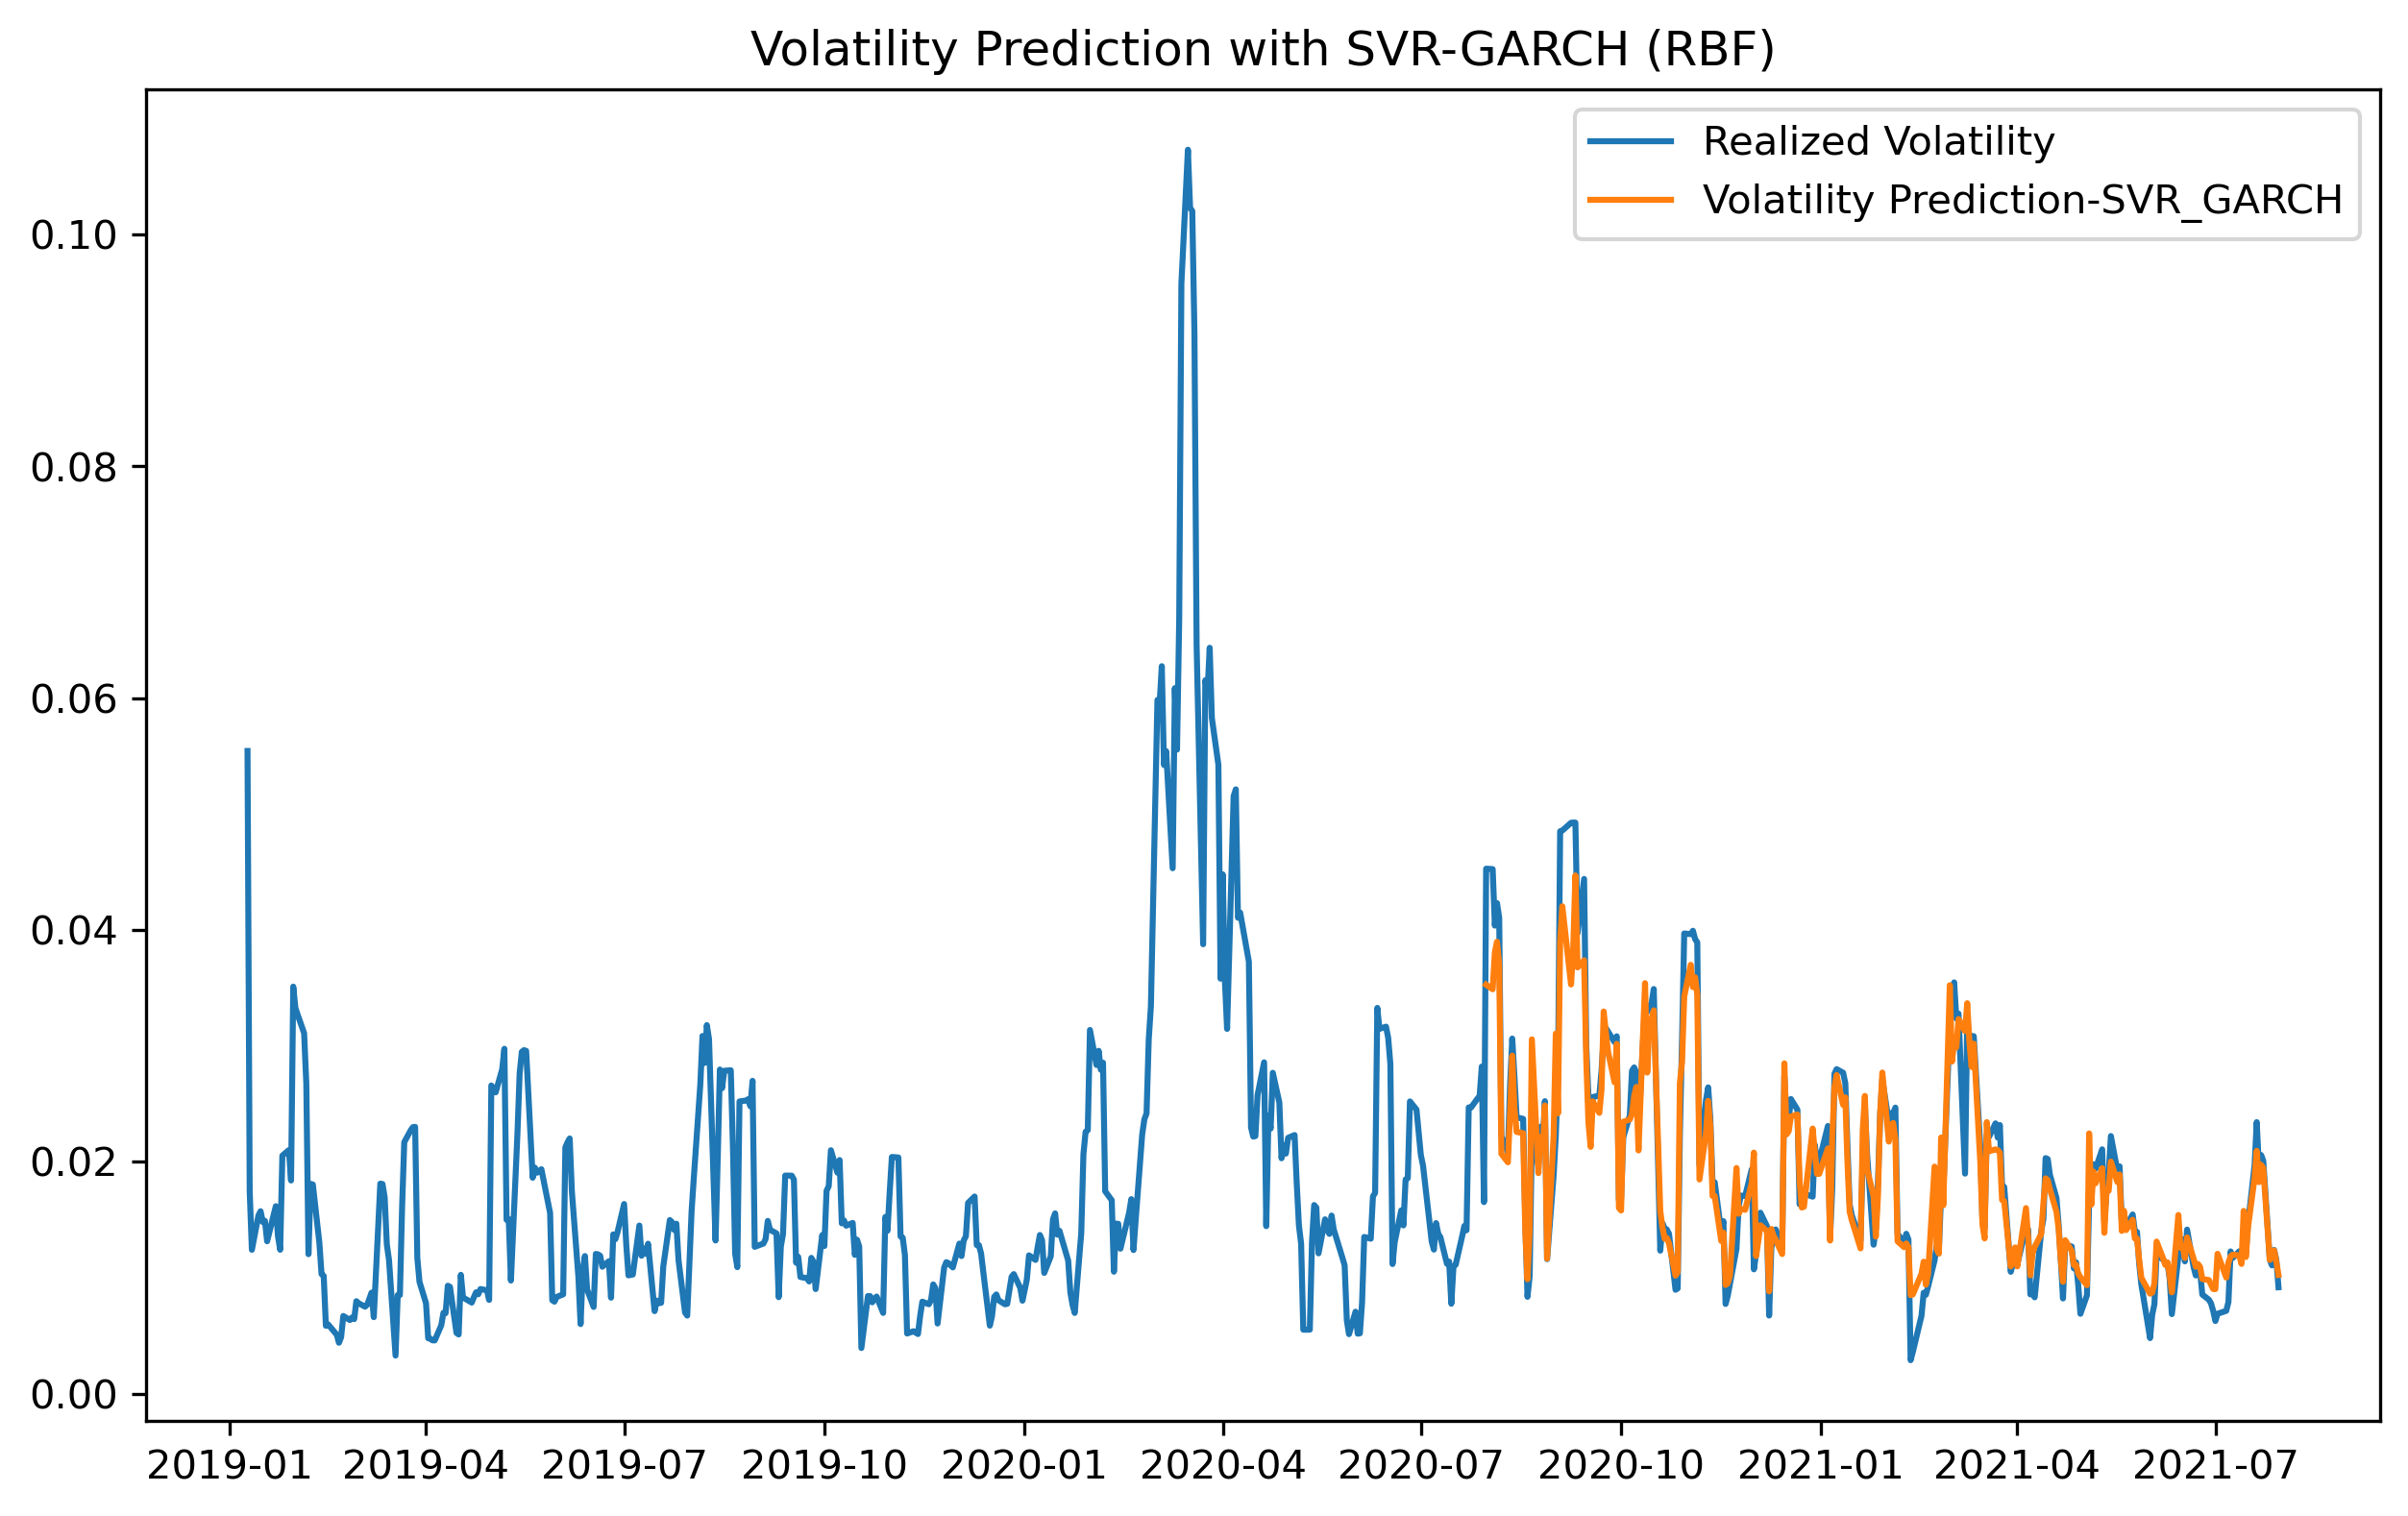

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

### SVR-GARCH Polynomial

In [62]:
para_grid = {'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_poly, para_grid)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_poly = clf.predict(X.iloc[-n:])

In [63]:
predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = ret.iloc[-n:].index

In [64]:
rmse_svr_poly = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                            predict_svr_poly / 100))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'\
      .format(rmse_svr_poly))

The RMSE value of SVR with Polynomial Kernel is 0.004992


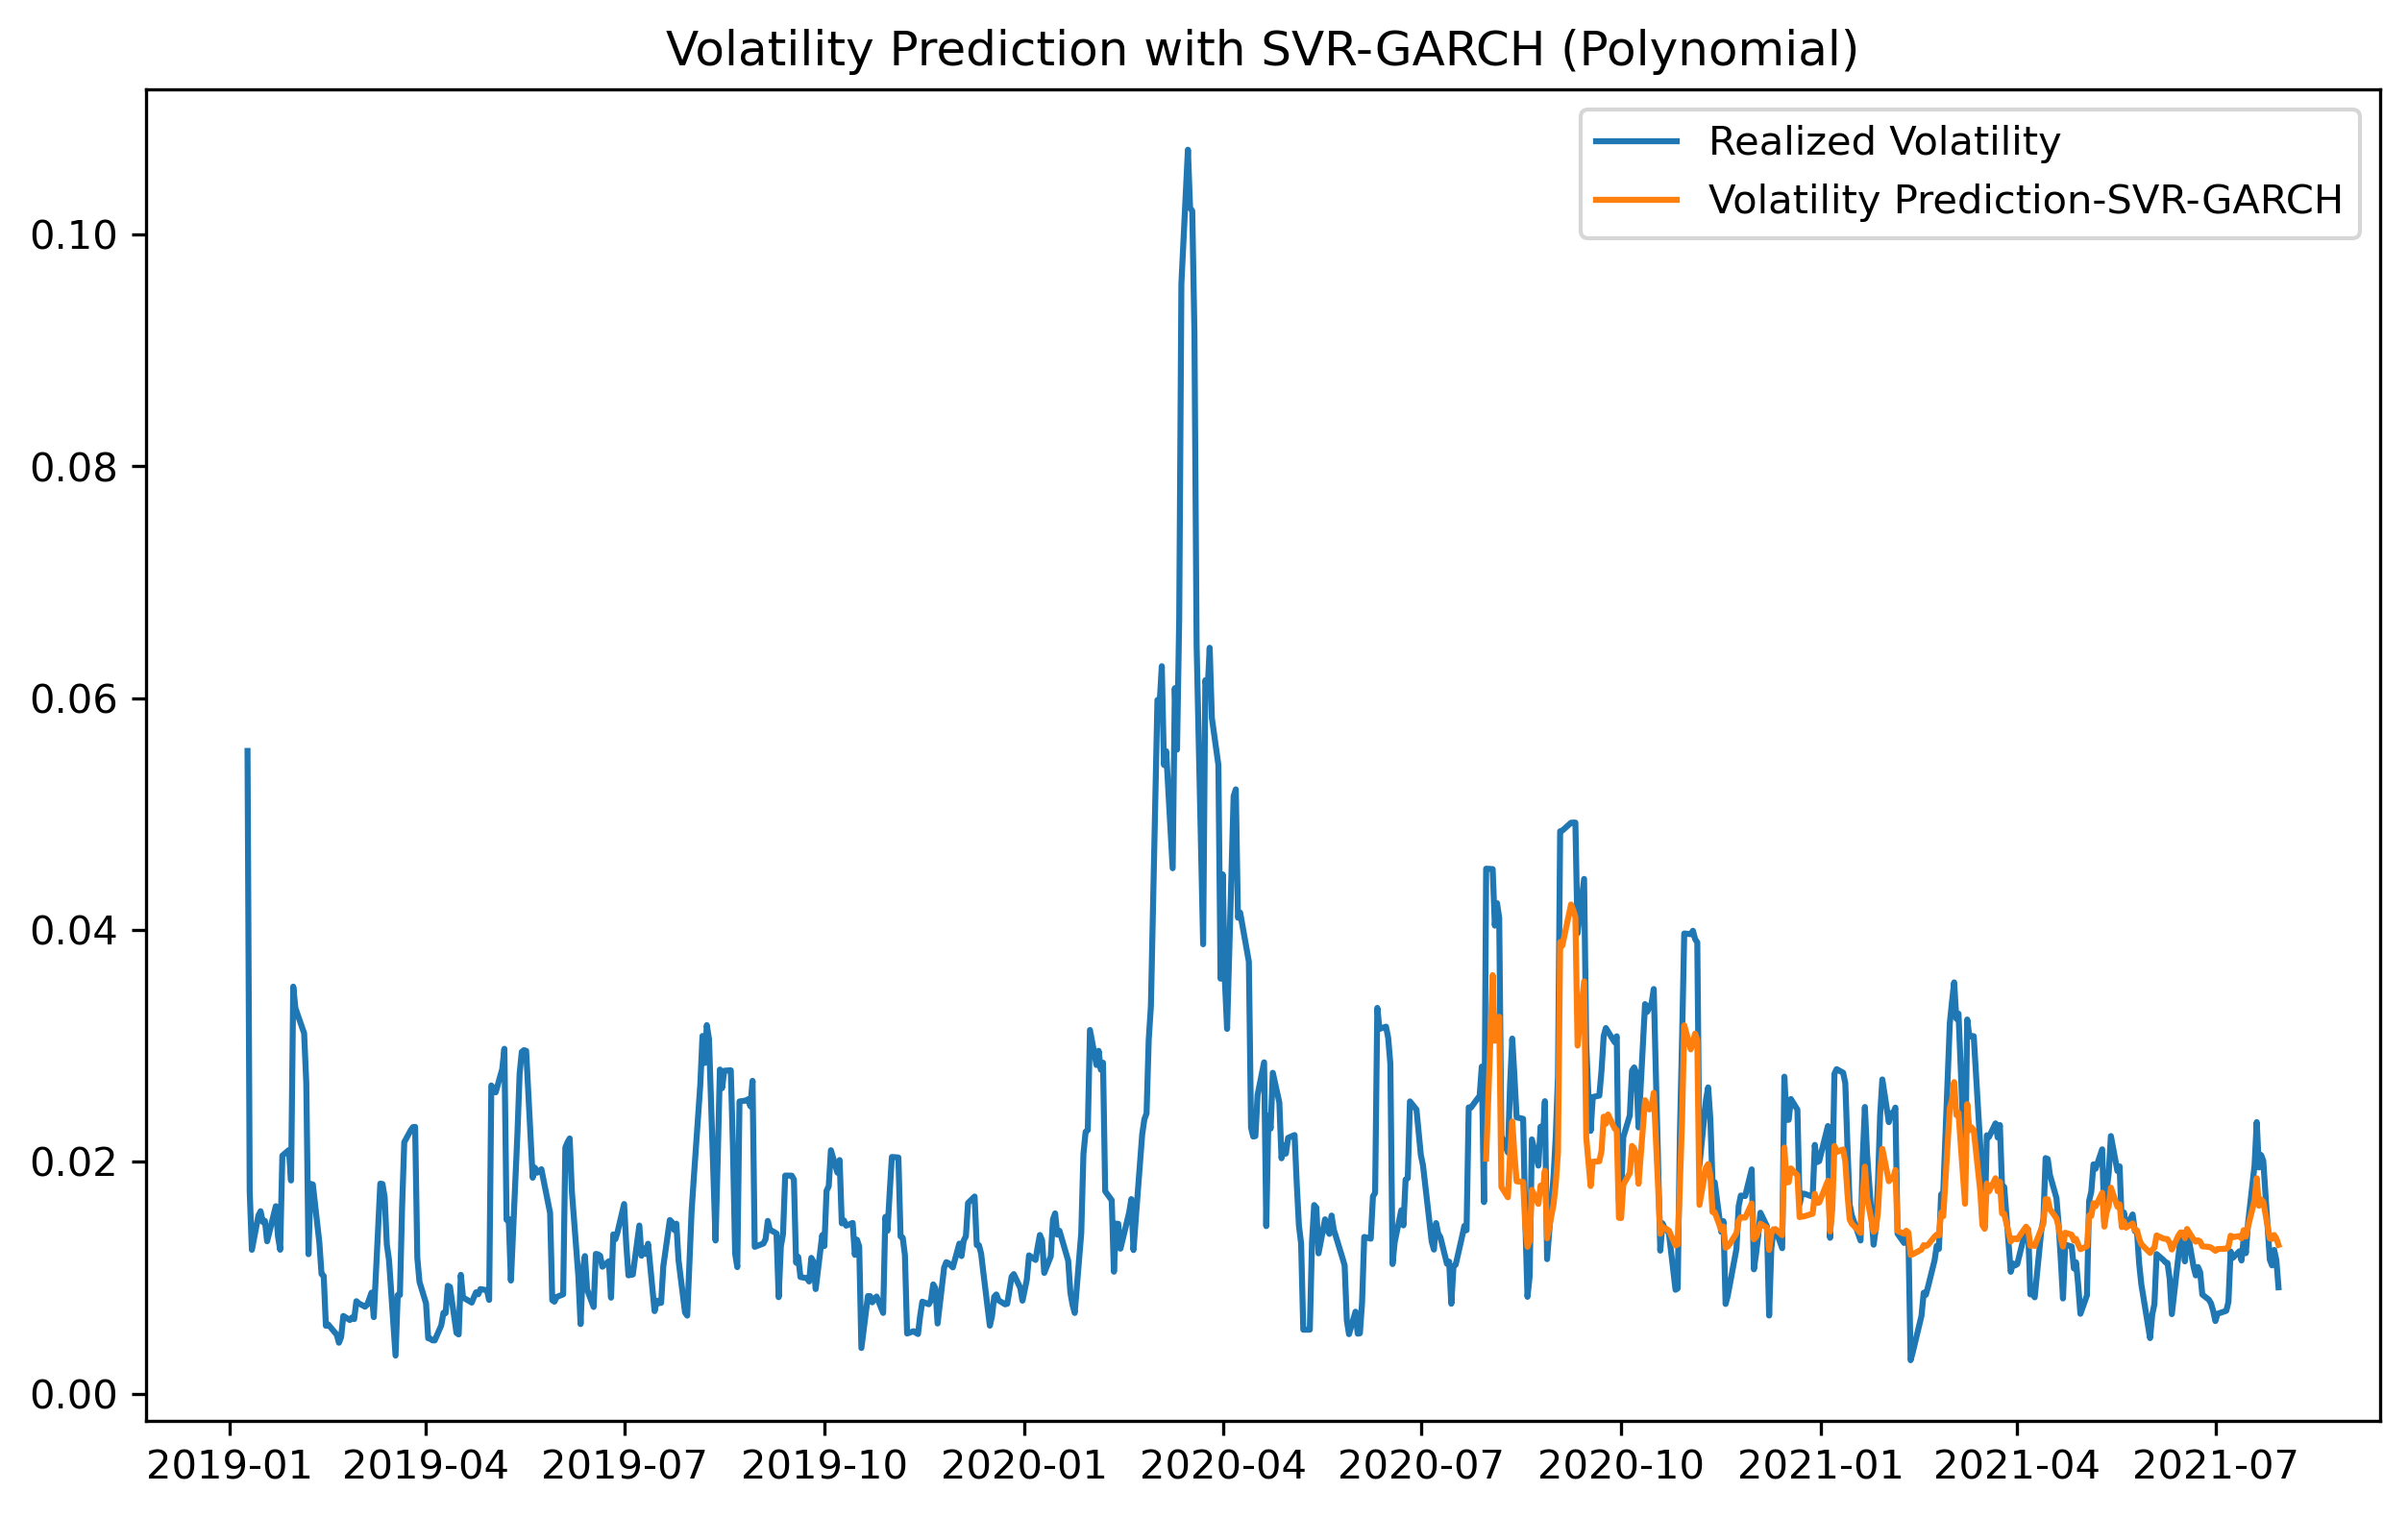

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Polynomial)',
          fontsize=12)
plt.legend()
plt.show()

## NN-GARCH

In [66]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1) 
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
               'max_iter': [500, 1000],
               'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])

In [67]:
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index

In [68]:
rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                      NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

The RMSE value of NN is 0.001757


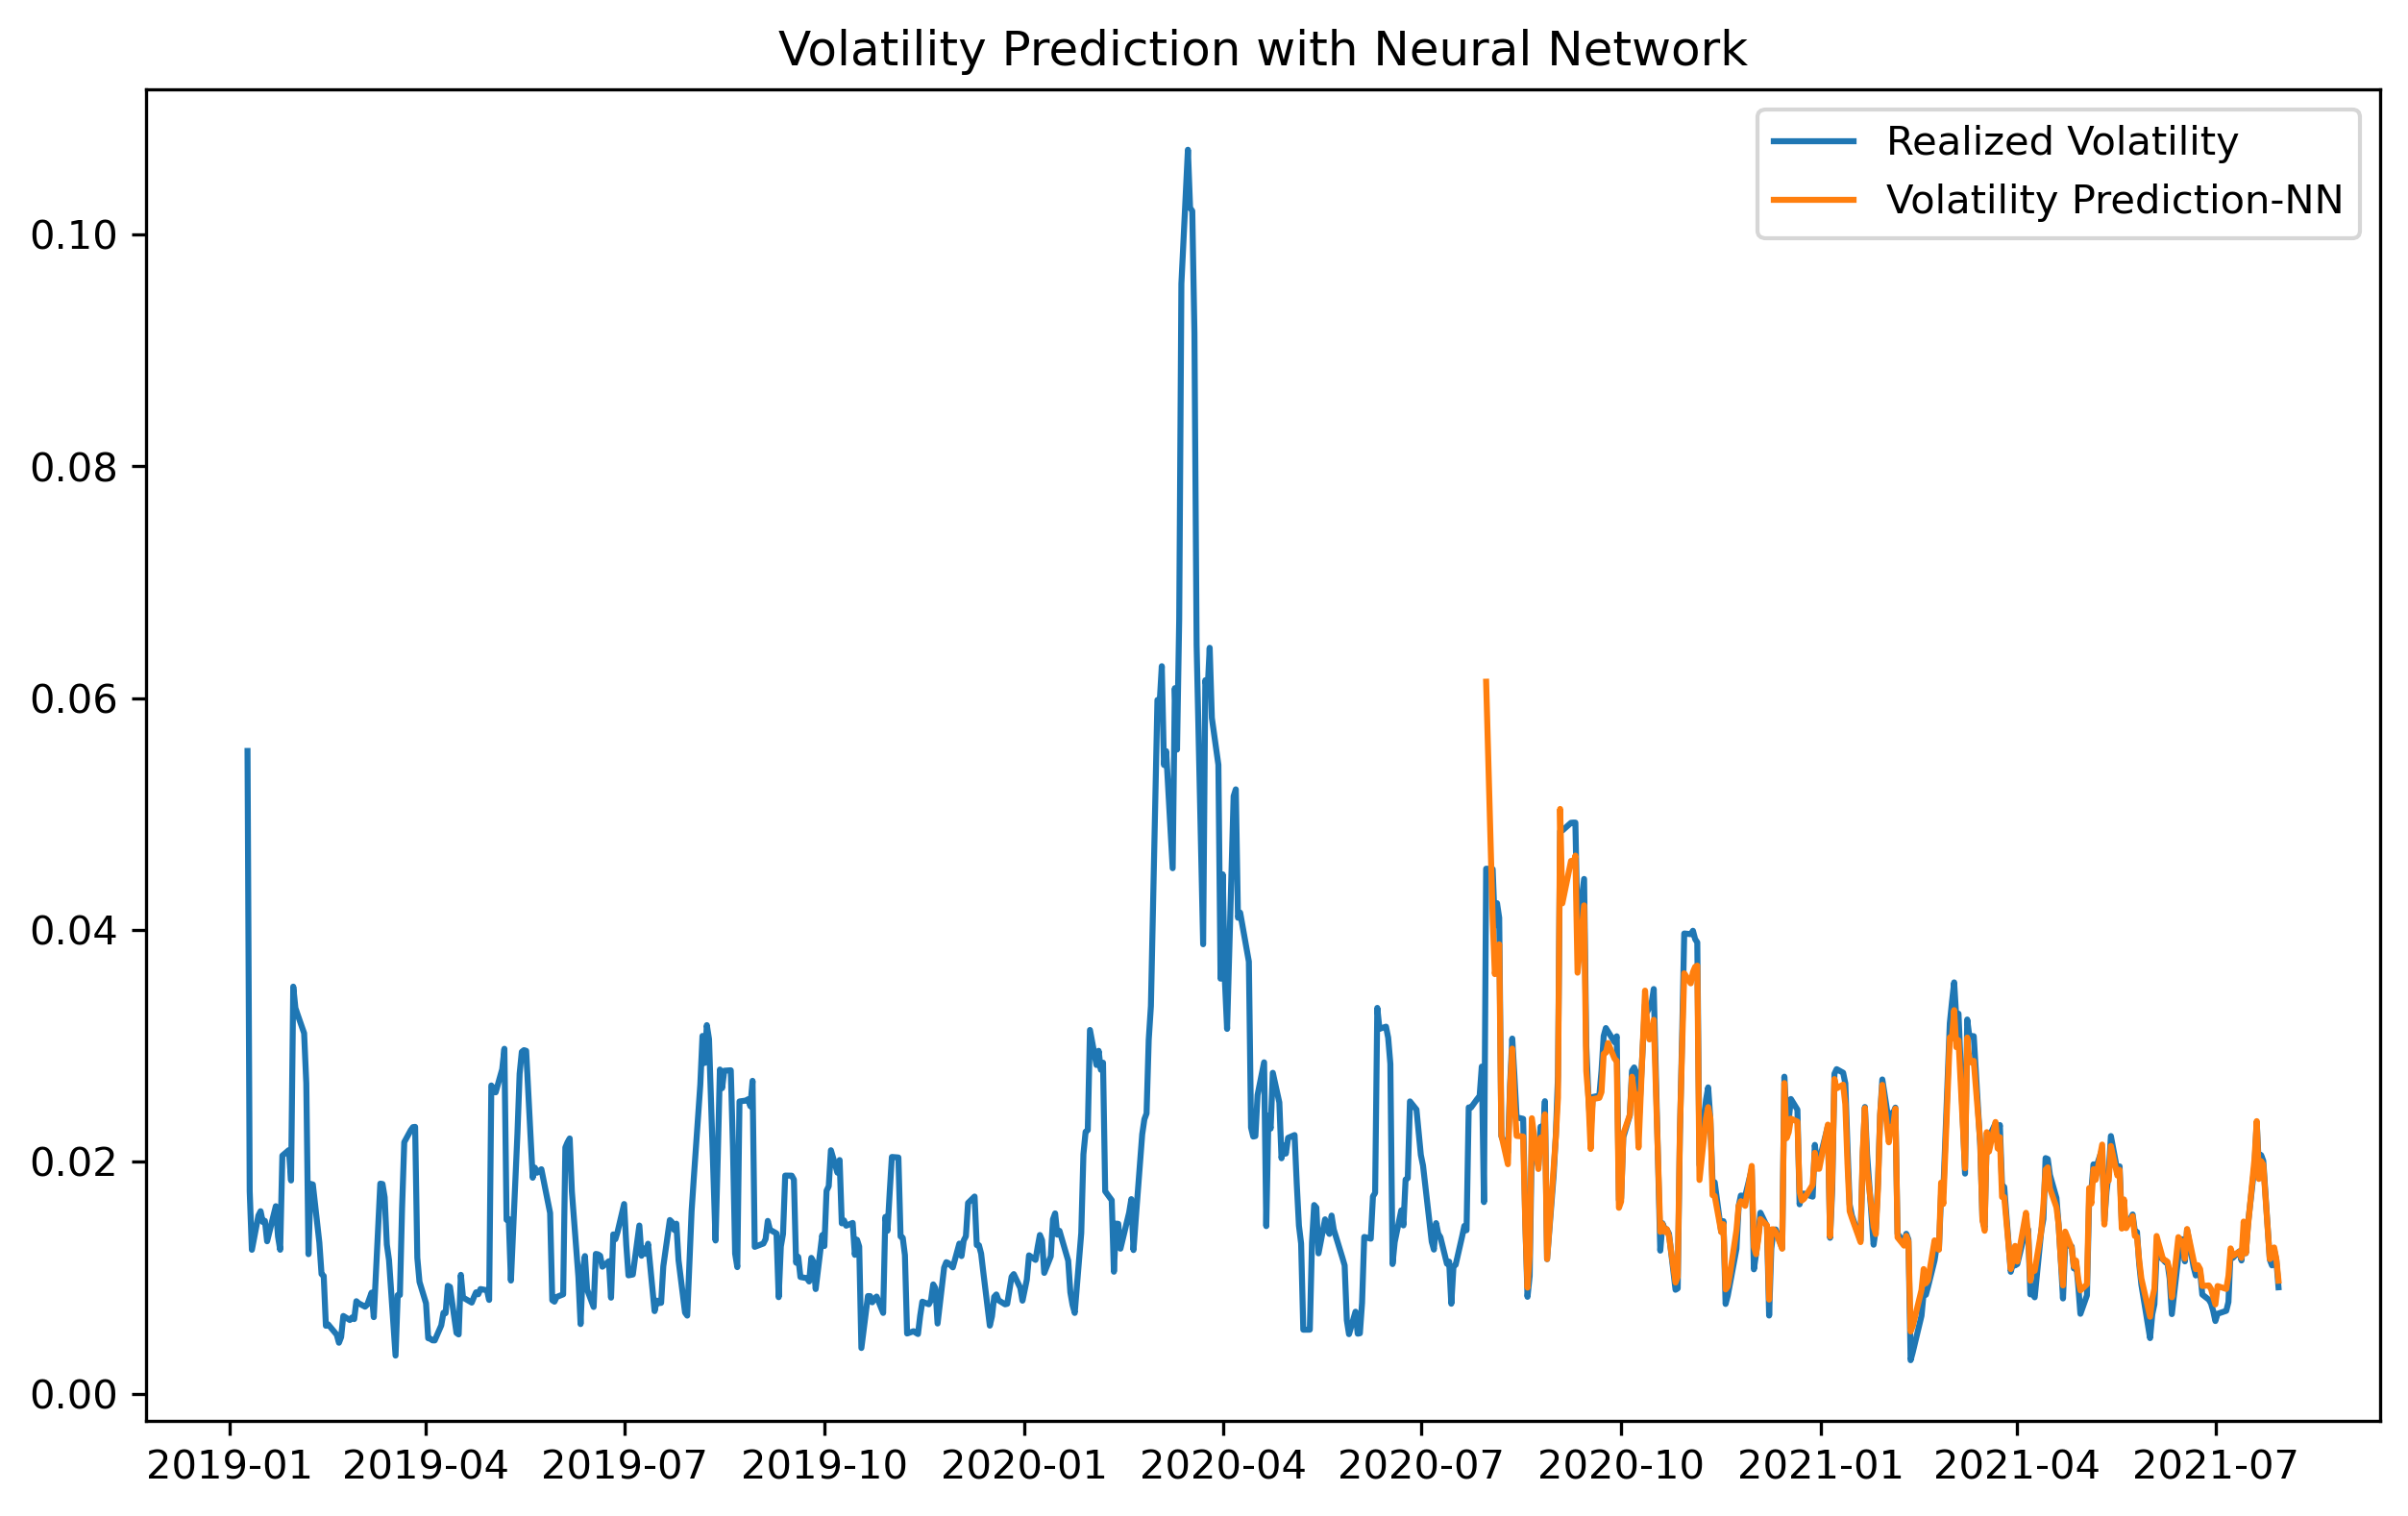

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

## DL-GARCH

In [70]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [71]:
model = keras.Sequential(
    [layers.Dense(256, activation="relu"),
     layers.Dense(128, activation="relu"),
     layers.Dense(1, activation="linear"),])

In [72]:
model.compile(loss='mse', optimizer='rmsprop')

In [73]:
epochs_trial = np.arange(100, 400, 4)
batch_trial = np.arange(100, 400, 4)
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
              realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                            DL_predict.flatten() / 100)))
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))

8/8 [==============================] - 0s 714us/step
DL_RMSE_1:0.002353
8/8 [==============================] - 0s 644us/step
DL_RMSE_2:0.001900
8/8 [==============================] - 0s 787us/step
DL_RMSE_3:0.002158
8/8 [==============================] - 0s 714us/step
DL_RMSE_4:0.003086


In [74]:
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = ret.iloc[-n:].index

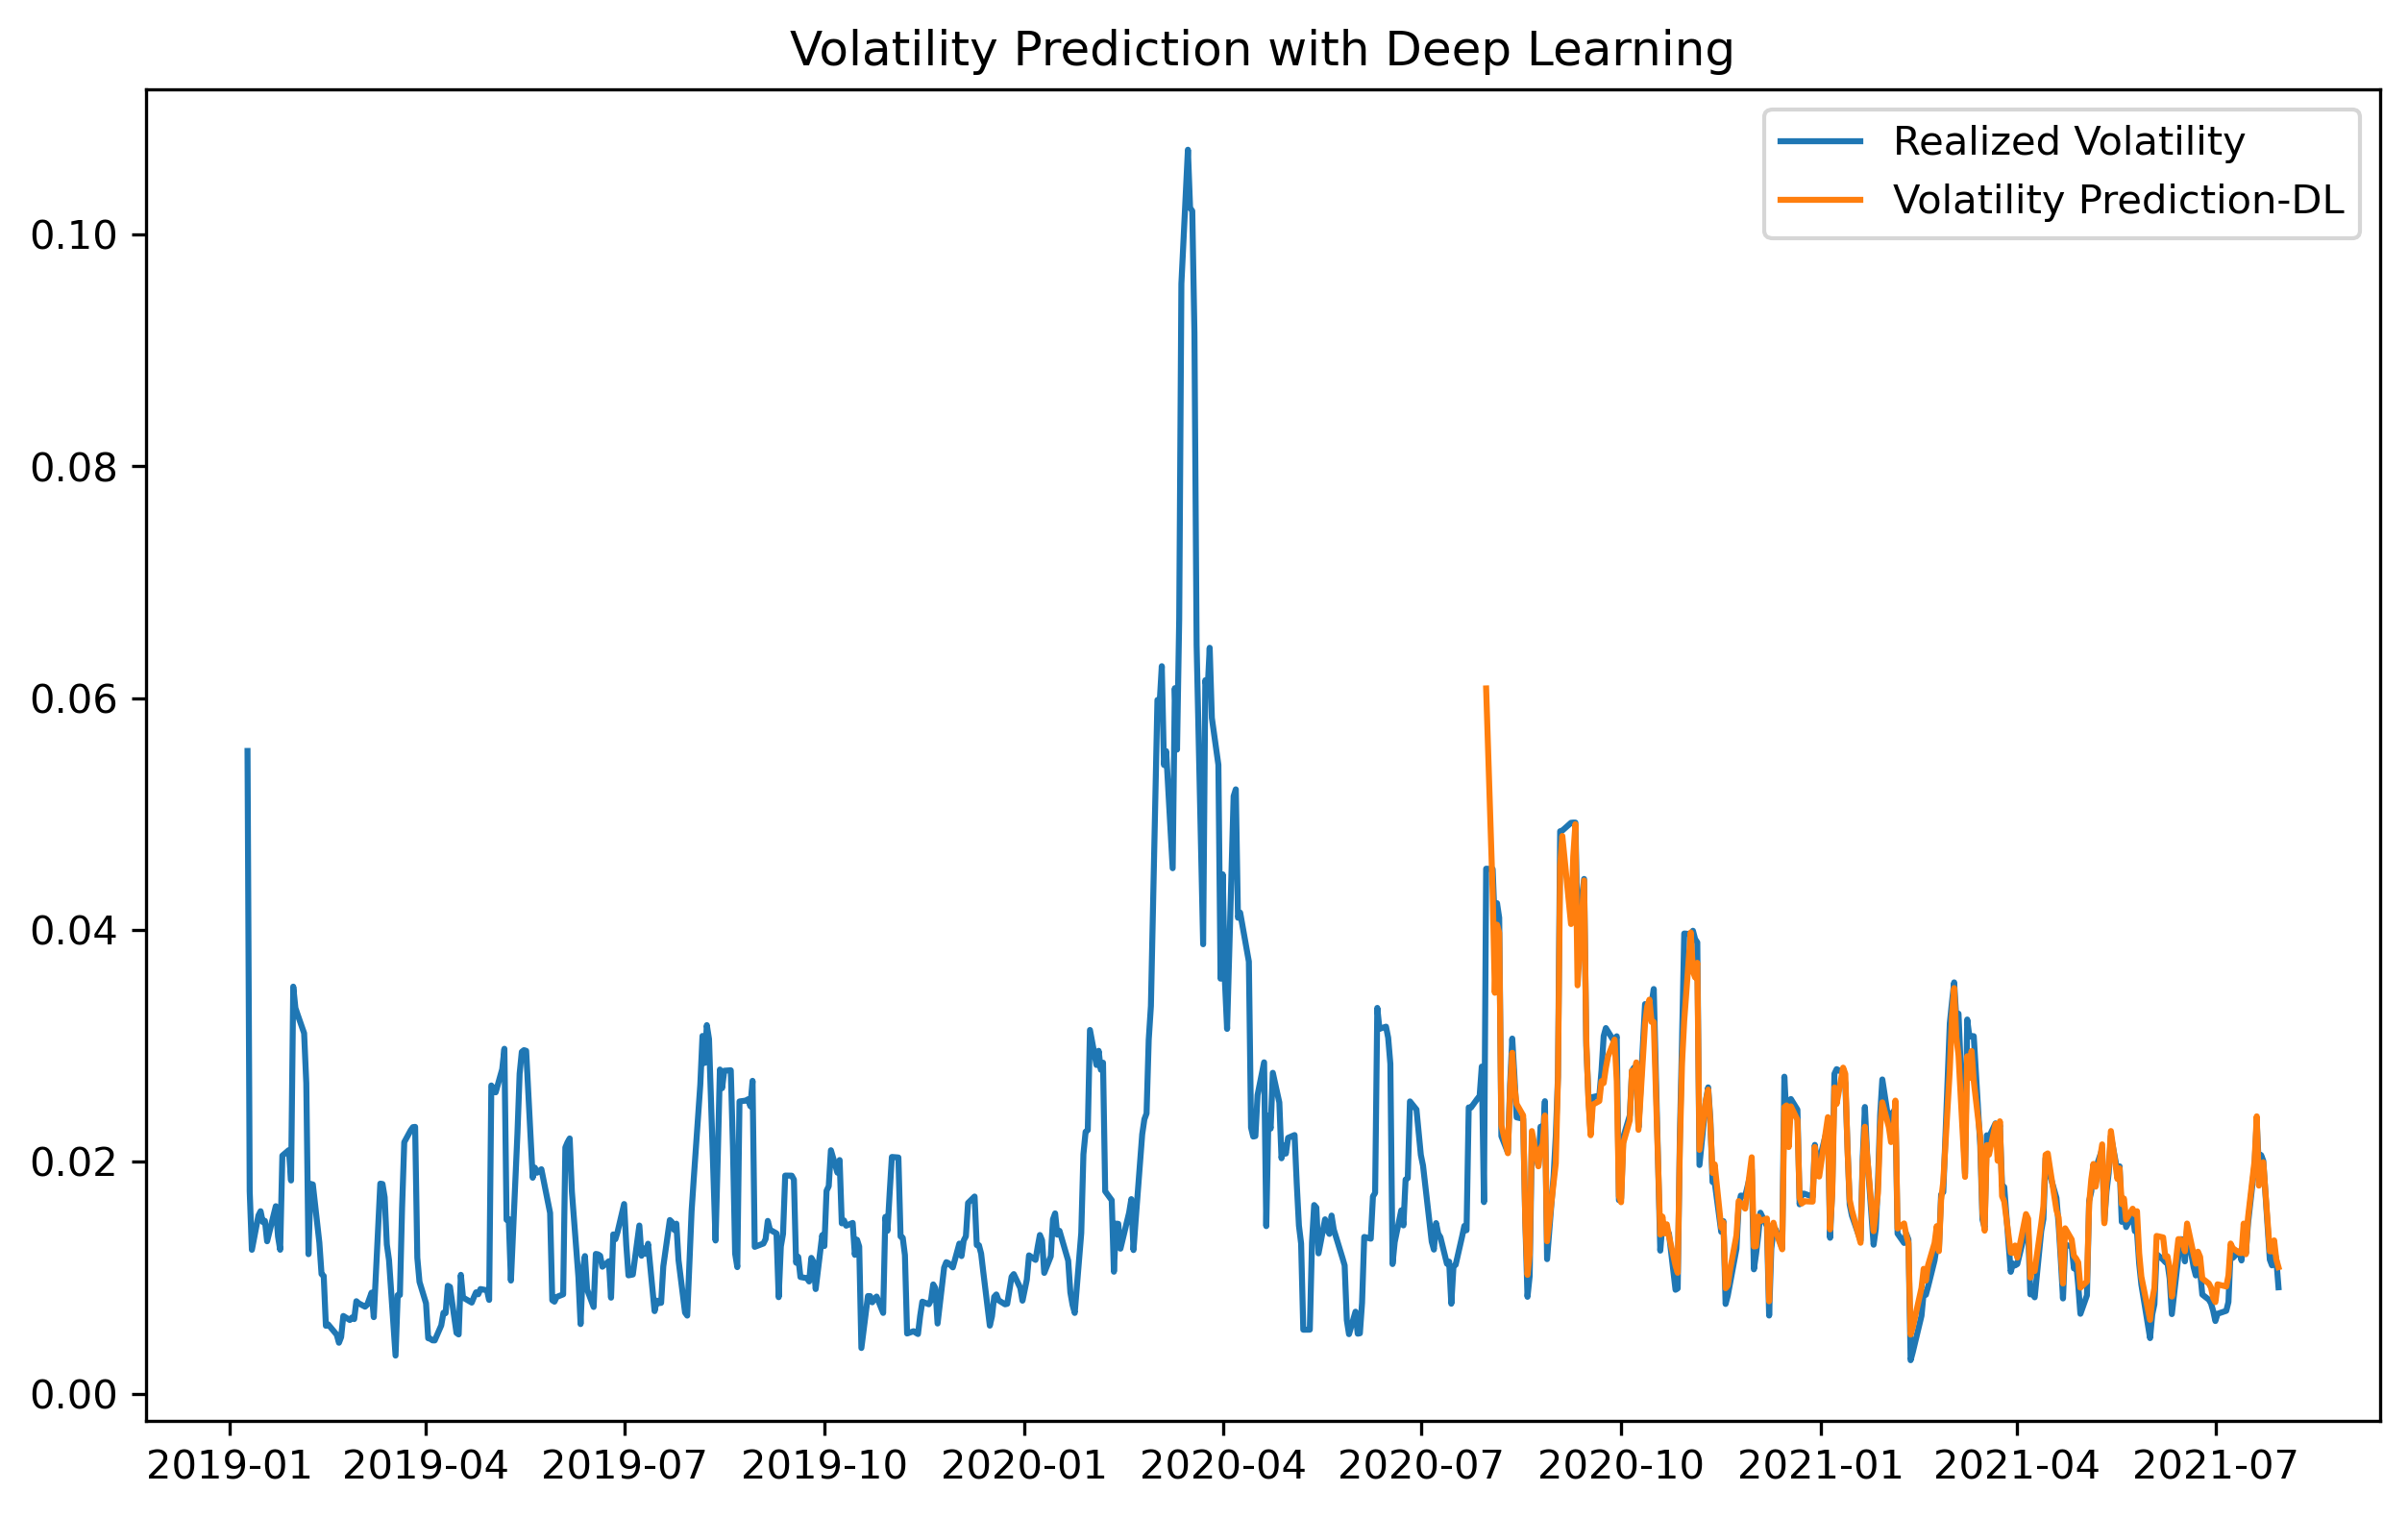

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()

## Bayesian Approach

In [76]:
import quantecon as qe
from quantecon import MarkovChain
import networkx as nx
from pprint import pprint 

In [77]:
P = [[0.5, 0.2, 0.3],
     [0.2, 0.3, 0.5],
     [0.2, 0.2, 0.6]]

mc = qe.MarkovChain(P, ('studying', 'travelling', 'sleeping'))
mc.is_irreducible

True

In [78]:
states = ['studying', 'travelling', 'sleeping']
initial_probs = [0.5, 0.3, 0.6]
state_space = pd.Series(initial_probs, index=states, name='states')

In [79]:
q_df = pd.DataFrame(columns=states, index=states)
q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.5, 0.2, 0.3]
q_df.loc[states[1]] = [0.2, 0.3, 0.5]
q_df.loc[states[2]] = [0.2, 0.2, 0.6]

In [80]:
def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges
edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

{('sleeping', 'sleeping'): 0.6,
 ('sleeping', 'studying'): 0.2,
 ('sleeping', 'travelling'): 0.2,
 ('studying', 'sleeping'): 0.3,
 ('studying', 'studying'): 0.5,
 ('studying', 'travelling'): 0.2,
 ('travelling', 'sleeping'): 0.5,
 ('travelling', 'studying'): 0.2,
 ('travelling', 'travelling'): 0.3}


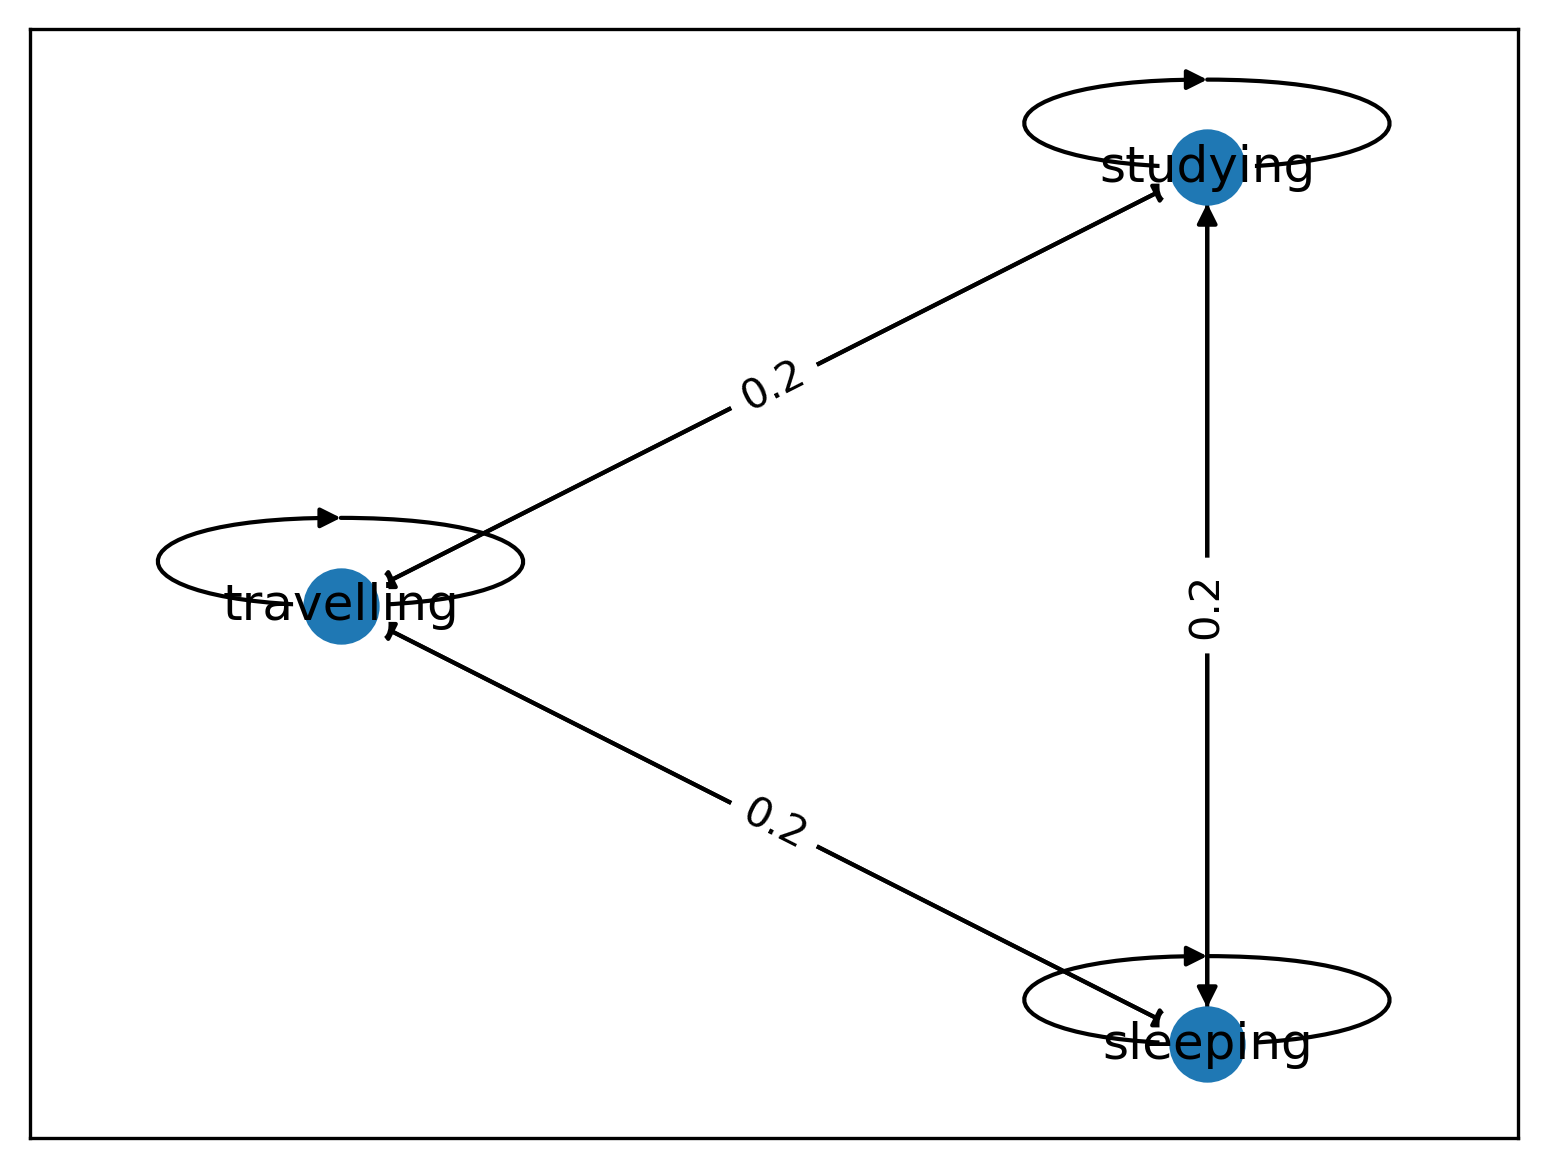

In [81]:
G = nx.MultiDiGraph()
G.add_nodes_from(states)
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)
edge_labels = {(n1, n2):d['label'] for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_agraph.write_dot(G, 'mc_states.dot')

In [82]:
import pyflux as pf
from scipy.stats import kurtosis

In [83]:
model = pf.GARCH(ret.values, p=1, q=1)
print(model.latent_variables)
model.adjust_prior(1, pf.Normal())
model.adjust_prior(2, pf.Normal())
x = model.fit(method='M-H', iterations='1000')
print(x.summary())

Index    Latent Variable           Prior           Prior Hyperparameters     V.I. Dist  Transform 
======== ========================= =============== ========================= ========== ==========
0        Vol Constant              Normal          mu0: 0, sigma0: 3         Normal     exp       
1        q(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
2        p(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
3        Returns Constant          Normal          mu0: 0, sigma0: 3         Normal     None      
Acceptance rate of Metropolis-Hastings is 0.3627

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.371675
GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Meth

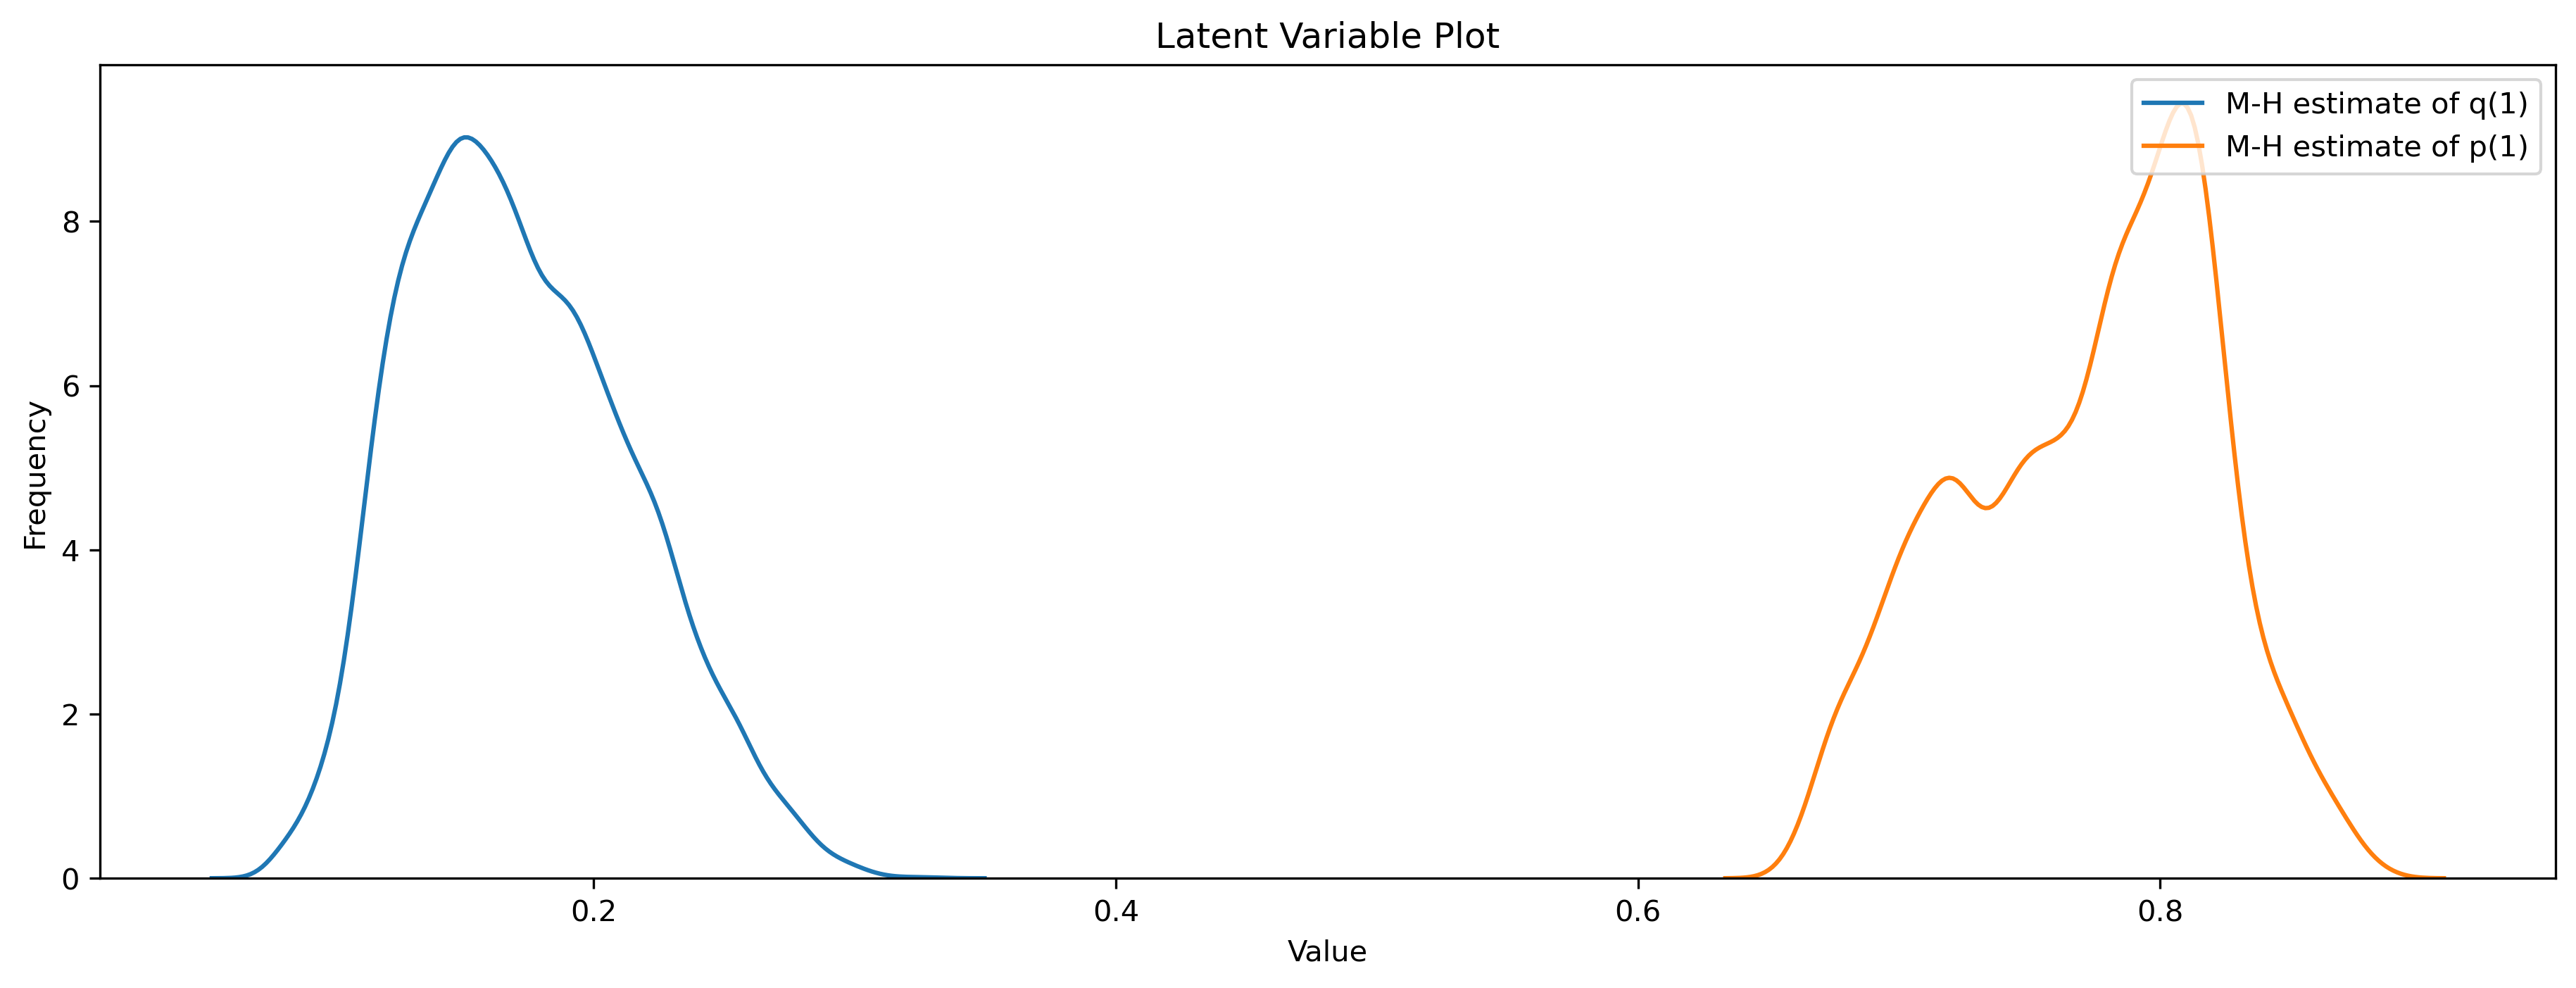

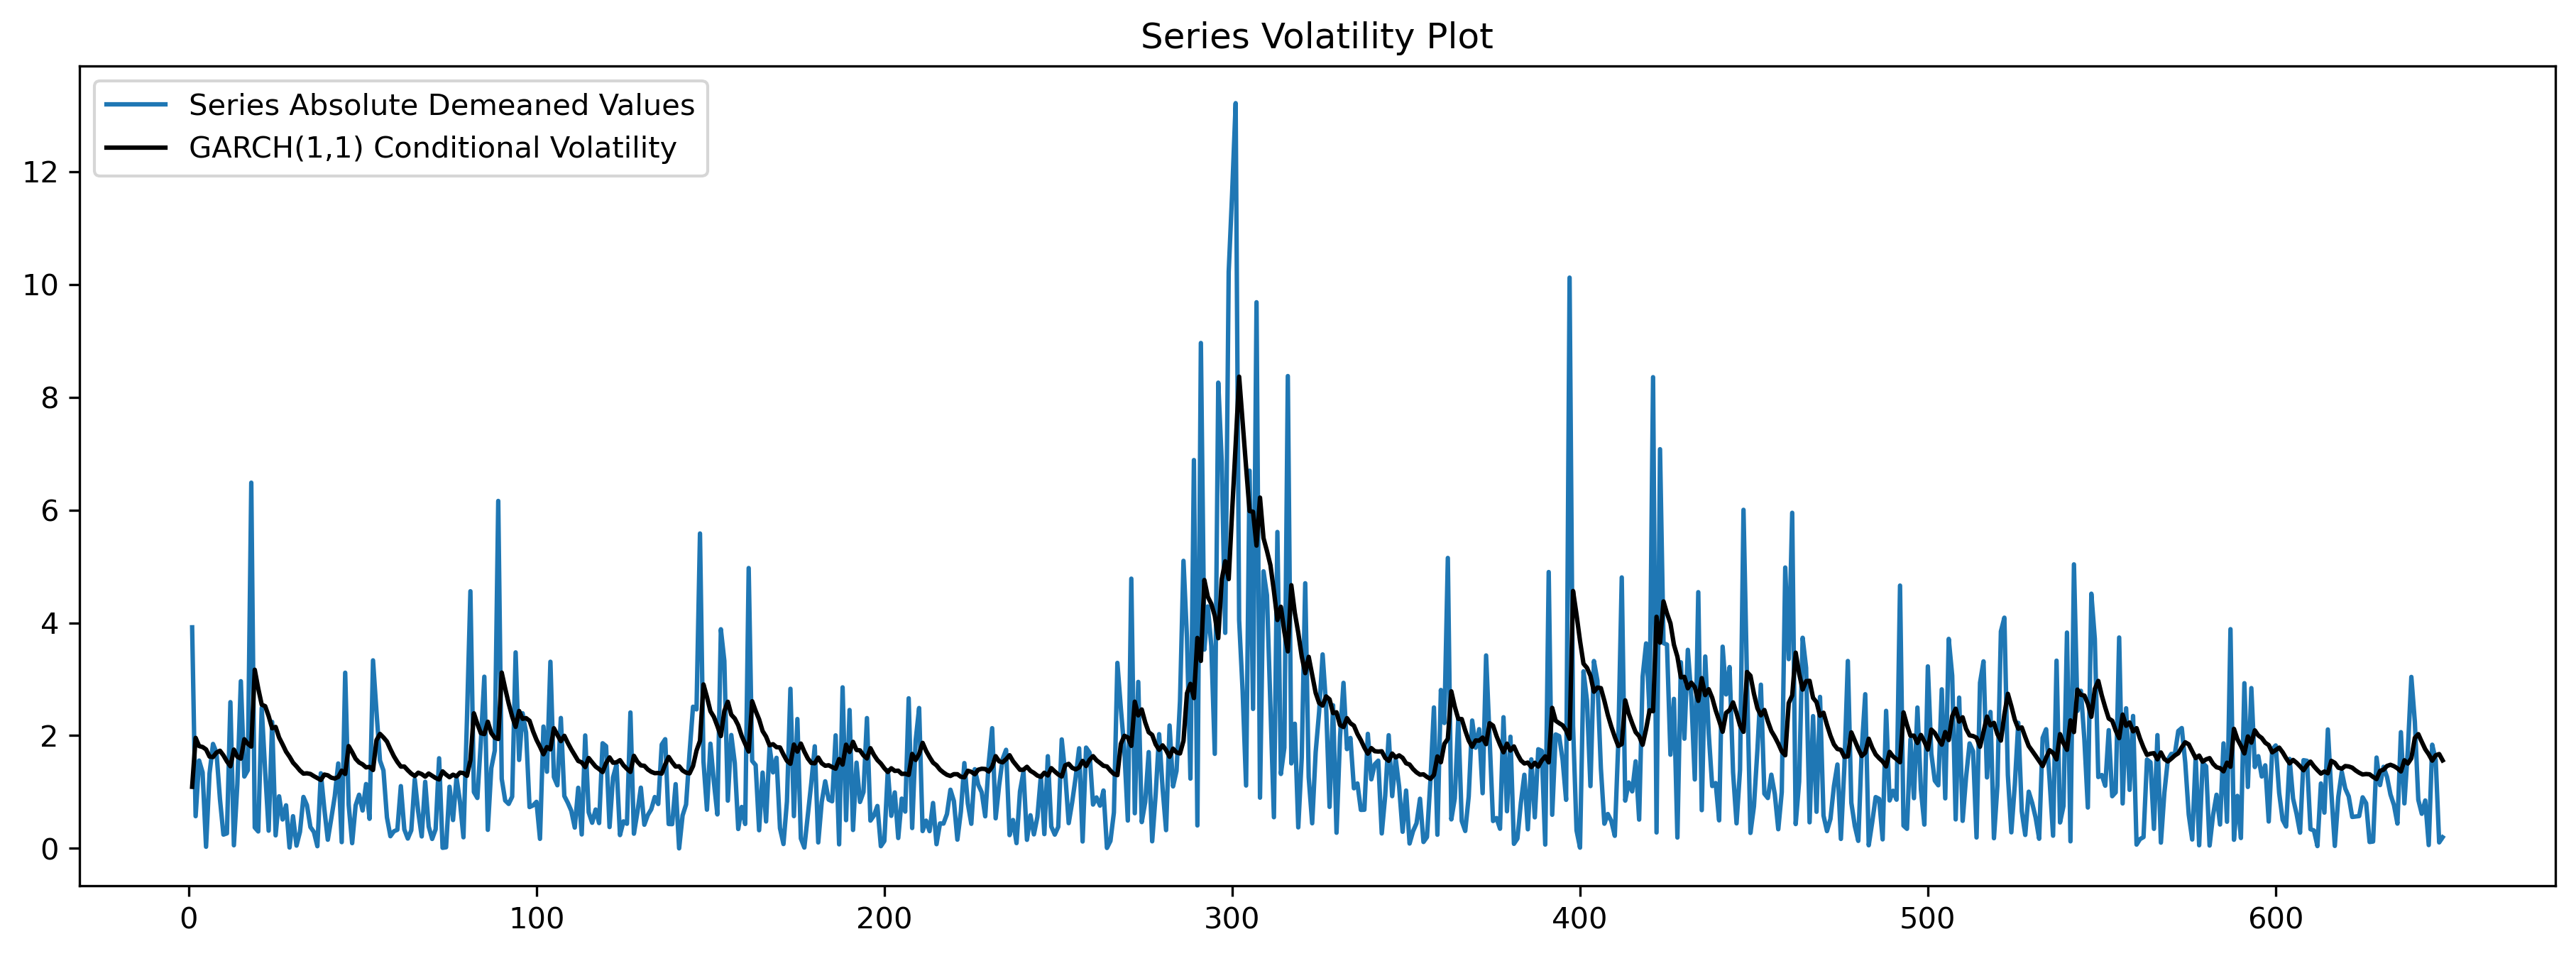

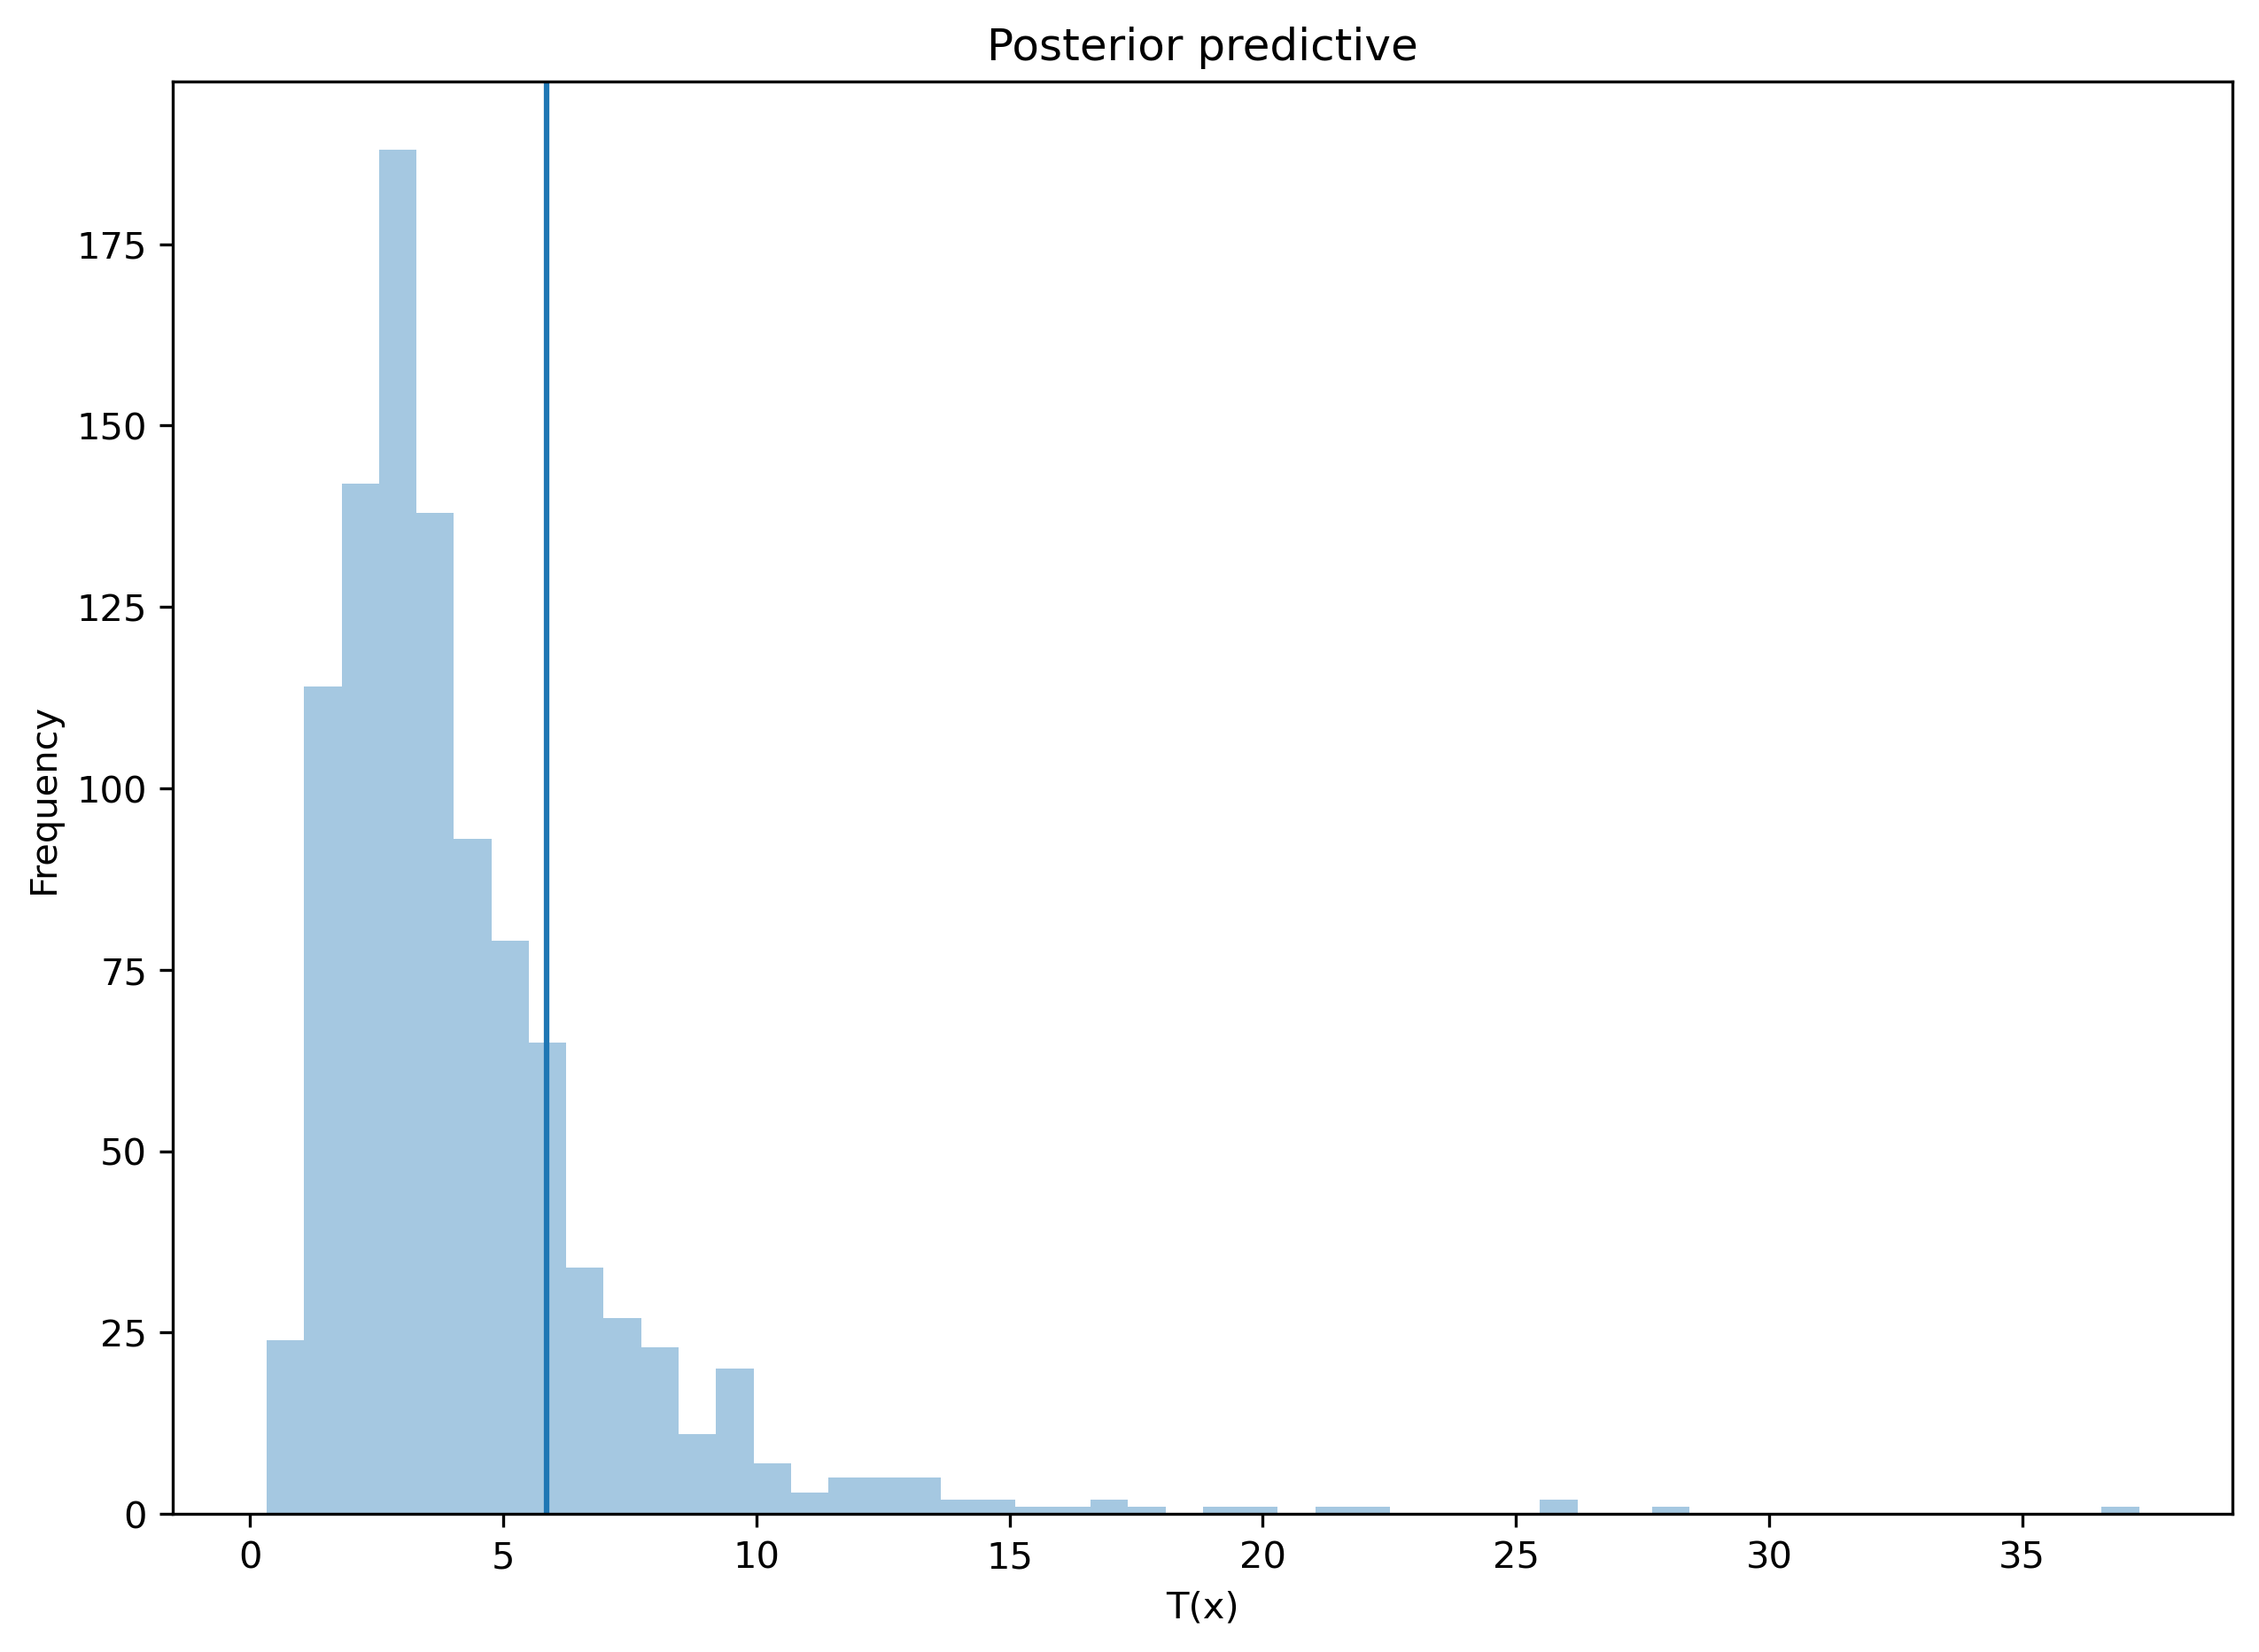

In [84]:
model.plot_z([1, 2])
model.plot_fit(figsize=(15, 5))
model.plot_ppc(T=kurtosis, nsims=1000)

In [85]:
bayesian_prediction = model.predict_is(n, fit_method='M-H')

Acceptance rate of Metropolis-Hastings is 0.1252
Acceptance rate of Metropolis-Hastings is 0.20705
Acceptance rate of Metropolis-Hastings is 0.2856

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.293675


In [86]:
bayesian_RMSE = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                         bayesian_prediction.values / 100))
print('The RMSE of Bayesian model is {:.6f}'.format(bayesian_RMSE))

The RMSE of Bayesian model is 0.036297


In [87]:
bayesian_prediction.index = ret.iloc[-n:].index

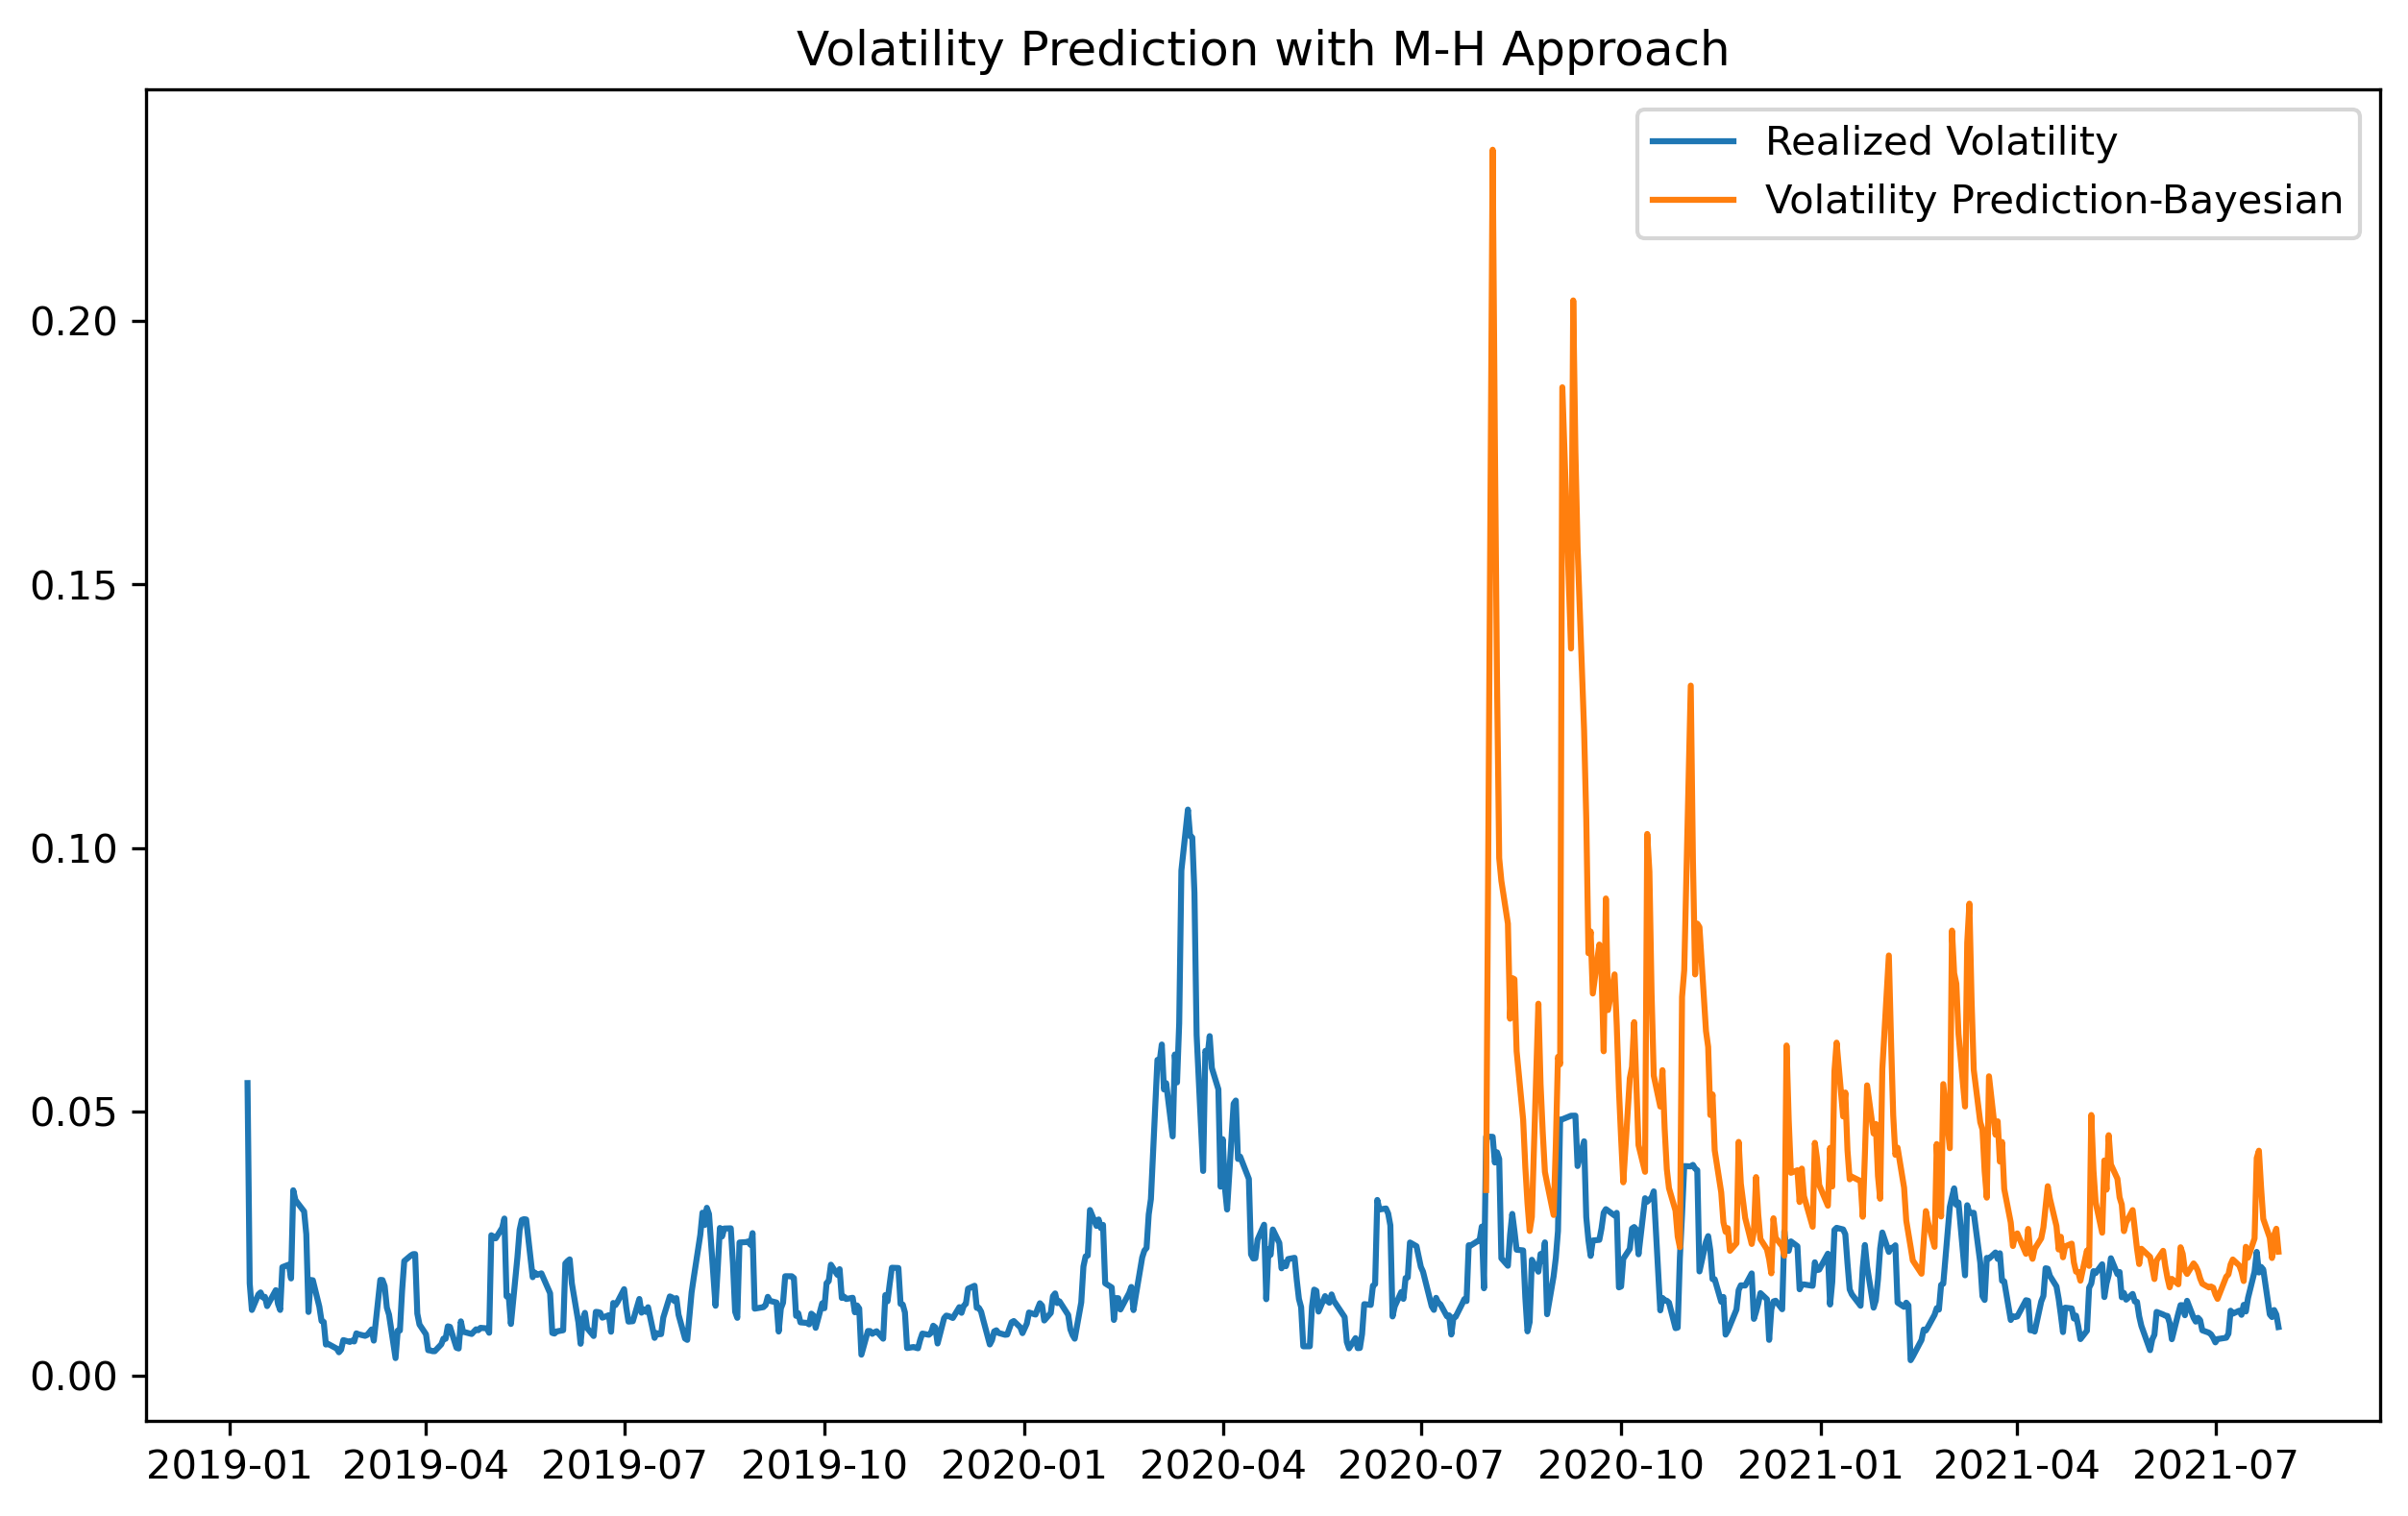

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,
         label='Realized Volatility')
plt.plot(bayesian_prediction['Series'] / 100,
         label='Volatility Prediction-Bayesian')
plt.title('Volatility Prediction with M-H Approach', fontsize=12)
plt.legend()
plt.show()